In [23]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

SHOW_PLOTS = True
SAVE_PLOTS = True

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DATA_DIR = "DE_DS_PracticeFiles/"     # folder containing USERS.csv, PRODUCTS.csv, ORDERS.csv, ORDER_ITEMS.csv
OUT_DIR  = "./out" # where to save outputs (tables & charts)
os.makedirs(OUT_DIR, exist_ok=True)

paths = {
    "users":       os.path.join(DATA_DIR, "USERS.csv"),
    "products":    os.path.join(DATA_DIR, "PRODUCTS.csv"),
    "orders":      os.path.join(DATA_DIR, "ORDERS.csv"),
    "order_items": os.path.join(DATA_DIR, "ORDER_ITEMS.csv"),
}
for k,p in paths.items():abs
def finish_fig(fig, filename=None):
    if SAVE_PLOTS and filename:
        fig.savefig(os.path.join(OUT_DIR, filename), bbox_inches="tight", dpi=150)
    if SHOW_PLOTS:
        plt.show()
    plt.close(fig)

    # ---------- tolerant column detection ----------
def detect_columns(df, patterns):
    def norm(s): return re.sub(r'[^a-z0-9]', '', str(s).lower())
    norm_cols = {norm(c): c for c in df.columns}
    out = []
    for p in patterns:
        npat = norm(p)
        for ncol, orig in norm_cols.items():
            if npat in ncol:
                out.append(orig)
    return list(dict.fromkeys(out))

def pick_first(lst, default=None):
    return lst[0] if (lst and len(lst)>0) else default

def first_match(df, pats):
    cols = detect_columns(df, pats)
    return cols[0] if cols else None



In [24]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    def _clean(c: str) -> str:
        c = str(c).strip().lower()
        c = re.sub(r"[^\w]+", "_", c)
        c = re.sub(r"(^_+|_+$)", "", c)
        return c
    out = df.copy()
    out.columns = [_clean(c) for c in out.columns]
    return out

def trim_strings(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    obj_cols = out.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        out[c] = out[c].astype(str).str.strip().replace({"": np.nan, "nan": np.nan})
    return out

def find_datetime_cols(df: pd.DataFrame):
    tokens = ("date","time","timestamp","created","updated","placed","shipped")
    return [c for c in df.columns if any(tok in c for tok in tokens)]

def coerce_datetimes_inplace(df: pd.DataFrame, dt_cols):
    for c in dt_cols:
        try:
            s = pd.to_datetime(df[c], errors="coerce", utc=True)
            df[c] = s.dt.tz_convert(None)
        except Exception:
            pass

def detect_columns(df, patterns):
    """
    Case/spacing/punctuation-insensitive substring match.
    """
    def norm(s): return re.sub(r'[^a-z0-9]', '', s.lower())
    norm_cols = {norm(c): c for c in df.columns}
    out = []
    for p in patterns:
        npat = norm(p)
        for ncol, orig in norm_cols.items():
            if npat in ncol:     # substring match on normalized names
                out.append(orig)
    # de-dup but keep order
    return list(dict.fromkeys(out))

def pick_first(lst, default=None):
    return (lst[0] if lst else default)

def numericize(df: pd.DataFrame, cols):
    for c in cols:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")


In [25]:
# Read raw users as-is (no dtype magic)
raw_users = pd.read_csv(paths["users"], dtype=str, keep_default_na=False, na_values=[])

# If the file has exactly one column (e.g., 'user_data'), find it:
users_json_col = raw_users.columns[0] if raw_users.shape[1] == 1 else "user_data"
if users_json_col not in raw_users.columns:
    # Fallback: assume the first column holds the JSONish data
    users_json_col = raw_users.columns[0]

def parse_users_row(s: str) -> dict:
    """
    Robust parser for rows like:
      {"id":93483,"":"/firstname/Brad","":"/lastname/Pitt", ...}
    Extracts:
      - id (int)
      - all '/key/value' pairs → key:value
    """
    out = {}
    text = (s or "").strip()

    # 1) Try to grab "id": <number> directly
    m = re.search(r'"id"\s*:\s*(\d+)', text)
    if m:
        out["id"] = int(m.group(1))

    # 2) Extract all '/key/value' style tokens, e.g. /firstname/Brad
    #    Allow letters, digits, underscore, hyphen in keys; values: stop at comma/quote/brace/bracket
    pairs = re.findall(r'/([\w\-]+)/([^,}"\]]+)', text)
    for k, v in pairs:
        out[k.lower()] = v.strip()

    # 3) If the row is actually valid JSON with usable keys, merge them
    try:
        obj = json.loads(text)
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k and k.strip():  # ignore "" keys
                    out[k.strip().lower()] = v
    except Exception:
        pass

    return out

parsed_users = [parse_users_row(s) for s in raw_users[users_json_col]]
users = pd.DataFrame(parsed_users)

# Optional: rename common fields to conventional names
rename_map = {
    "firstname": "first_name",
    "lastname": "last_name",
    "e_mail": "email",
}
users.rename(columns=rename_map, inplace=True)

# Standard cleanup
users = standardize_columns(users)
users = trim_strings(users)

# Parse any datetime-like columns
dt_cols = find_datetime_cols(users)
coerce_datetimes_inplace(users, dt_cols)
users.attrs["datetime_cols"] = dt_cols

print("Users parsed shape:", users.shape)
users.head()


Users parsed shape: (100000, 11)


,id,first_name,last_name,email,age,gender,state,street,postalcode,country,city
0,93483,Brad,Ferguson,bradferguson@example.net,16,M,Acre,8427 Rachel Drive Suite 095,69980-000,Brasil,NaN
1,685,Erica,Levine,ericalevine@example.com,37,F,Acre,3160 Lisa Springs Suite 593,69980-000,Brasil,NaN
2,99142,Austin,Simmons,austinsimmons@example.org,21,M,Acre,62944 Miles Avenue,69980-000,Brasil,NaN
3,38974,Linda,King,lindaking@example.com,20,F,Acre,26711 George Centers Suite 634,69980-000,Brasil,NaN
4,46889,Larry,Howard,larryhoward@example.net,39,M,Acre,438 Richard Roads,69980-000,Brasil,NaN


In [26]:
# Strategy:
#  - If file text starts with '[' → parse whole file as a JSON array
#  - Else read as CSV and parse the first cell as a JSON array

with open(paths["products"], "r", encoding="utf-8") as f:
    txt = f.read().strip()

products = None
if txt.startswith("["):
    try:
        products = pd.DataFrame(json.loads(txt))
    except Exception:
        products = None

if products is None:
    # Try as one-cell CSV
    tmp = pd.read_csv(paths["products"], dtype=str, keep_default_na=False, na_values=[])
    first_cell = tmp.iloc[0, 0]
    products = pd.DataFrame(json.loads(first_cell))

# Standard cleanup
products = standardize_columns(products)
products = trim_strings(products)
dt_cols = find_datetime_cols(products)
coerce_datetimes_inplace(products, dt_cols)
products.attrs["datetime_cols"] = dt_cols

print("Products parsed shape:", products.shape)
products.head()


Products parsed shape: (29120, 9)


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


In [39]:
orders      = pd.read_csv(paths["orders"], low_memory=False)
order_items = pd.read_csv(paths["order_items"], low_memory=False)

orders      = standardize_columns(orders)
order_items = standardize_columns(order_items)

orders      = trim_strings(orders)
order_items = trim_strings(order_items)

coerce_datetimes_inplace(orders, find_datetime_cols(orders))
coerce_datetimes_inplace(order_items, find_datetime_cols(order_items))

orders.attrs["datetime_cols"] = find_datetime_cols(orders)
order_items.attrs["datetime_cols"] = find_datetime_cols(order_items)

print("Orders shape:", orders.shape, "| Order items shape:", order_items.shape)
orders.head(), order_items.head()


Orders shape: (82480, 9) | Order items shape: (63987, 11)


(   order_id  user_id     status gender          created_at returned_at shipped_at delivered_at  num_of_item
 0         1        1  Cancelled      F 2020-03-20 11:43:00         NaN        NaT          NaN            2
 1        17       11  Cancelled      F 2024-04-16 14:15:00         NaN        NaT          NaN            1
 2        78       52  Cancelled      F 2025-04-07 15:12:00         NaN        NaT          NaN            1
 3       101       74  Cancelled      F 2025-08-12 14:56:00         NaN        NaT          NaN            2
 4       106       78  Cancelled      F 2025-06-06 07:09:00         NaN        NaT          NaN            1,
        id  order_id  user_id  product_id  inventory_item_id      status          created_at shipped_at delivered_at returned_at  \
 0  102433     70865    56891       14235             276182  Processing 2024-06-06 04:30:37        NaT          NaN         NaN   
 1  172184    118909    95392       14235             464193  Processing 2023-01-

/var/folders/8s/kmd281414_3_sk09mpml3zvh0000gn/T/ipykernel_7707/135369112.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  months_covered = nonnull.dt.to_period("M").nunique()


,event,column,coverage_%,min_utc,max_utc,span_days
0,created_at,created_at,100.00,2019-01-10 00:24:00+00:00,2025-08-27 19:24:57.272875+00:00,2422
1,shipped_at,shipped_at,61.76,2019-01-12 02:55:00+00:00,2025-08-30 16:11:39.414889+00:00,2423
2,delivered_at,delivered_at,39.31,2019-01-16 02:47:00+00:00,2025-09-04 06:33:47.096178+00:00,2424
3,returned_at,returned_at,7.51,2019-02-05 02:47:00+00:00,2025-09-04 21:54:10.567408+00:00,2404


,metric,value
0,primary_date_key,created_at
1,primary_date_column,created_at
2,data_start_utc,2019-01-10 00:24:00+00:00
3,data_end_utc,2025-08-27 19:24:57.272875+00:00
4,window_days,2422
5,window_months,79.57
6,window_years,6.63
7,distinct_months_with_orders,80


,created_at,orders_per_month
0,2019-01-01 00:00:00+00:00,8
1,2019-02-01 00:00:00+00:00,17
2,2019-03-01 00:00:00+00:00,37
3,2019-04-01 00:00:00+00:00,57
4,2019-05-01 00:00:00+00:00,67


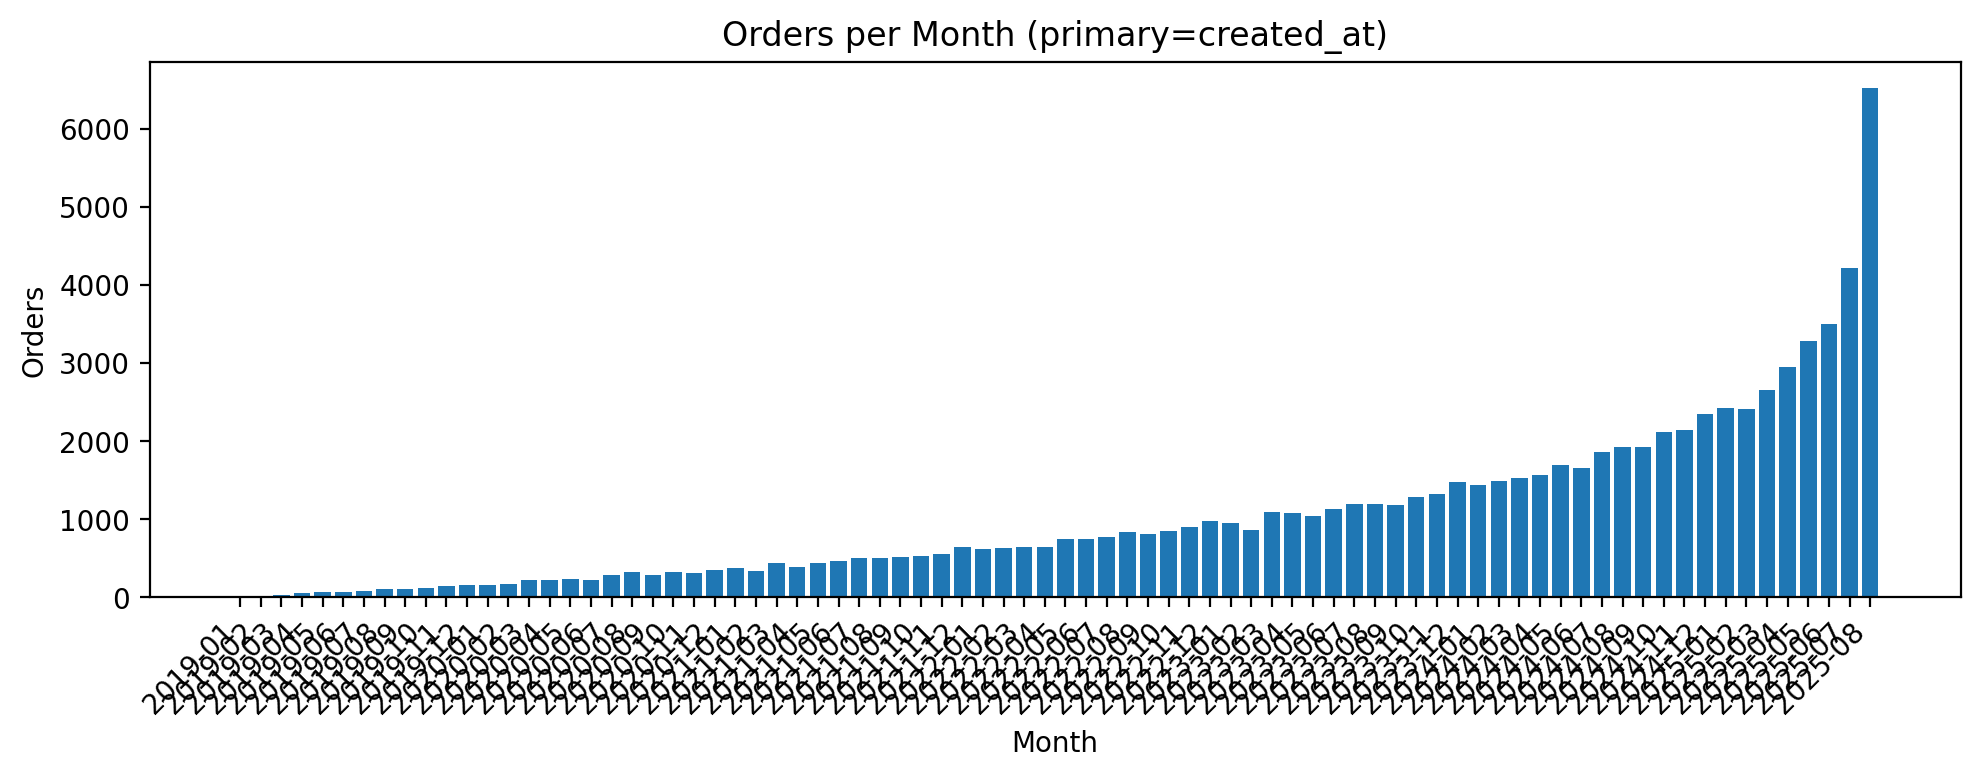

In [42]:

# --- normalize all detected events to UTC (tz-aware) ---
orders_dt = orders.copy()
for k, col in event_cols.items():
    if col:
        orders_dt[col] = to_dt_utc(orders_dt[col])

# --- choose a primary date column ---
# preference order if present; else pick the event with the highest coverage; else any datetime col
pref_order = ["created_at","paid_at","shipped_at","delivered_at"]
primary_key = next((k for k in pref_order if event_cols.get(k)), None)

if not primary_key:
    cover = {k: orders_dt[c].notna().mean() if c else 0 for k, c in event_cols.items()}
    primary_key = max(cover, key=cover.get) if any(cover.values()) else None

primary_col = event_cols.get(primary_key) if primary_key else None
if not primary_col:
    # fallback: any datetime-like column
    dt_cols = orders_dt.select_dtypes(include=["datetime64[ns, UTC]","datetime64[ns]"]).columns.tolist()
    primary_col = dt_cols[0] if dt_cols else None
    primary_key = primary_col or "n/a"

# --- compute overall window on primary ---
if primary_col:
    nonnull = orders_dt[primary_col].dropna()
    data_start_utc = nonnull.min()
    data_end_utc   = nonnull.max()
    window_days    = int((data_end_utc - data_start_utc).days) + 1 if pd.notna(data_start_utc) and pd.notna(data_end_utc) else np.nan
    window_months  = round(window_days/30.44, 2) if window_days == window_days else np.nan
    window_years   = round(window_days/365.25, 2) if window_days == window_days else np.nan
    months_covered = nonnull.dt.to_period("M").nunique()
else:
    data_start_utc = data_end_utc = pd.NaT
    window_days = window_months = window_years = months_covered = np.nan

# --- per-event min/max & coverage ---
event_summary = []
for k, col in event_cols.items():
    if col:
        s = orders_dt[col].dropna()
        event_summary.append({
            "event": k,
            "column": col,
            "coverage_%": round(orders_dt[col].notna().mean()*100, 2),
            "min_utc": s.min() if not s.empty else pd.NaT,
            "max_utc": s.max() if not s.empty else pd.NaT,
            "span_days": (s.max() - s.min()).days + 1 if len(s) else np.nan
        })
event_summary_df = pd.DataFrame(event_summary).sort_values("coverage_%", ascending=False)
display(event_summary_df)

# --- overall date stats table ---
date_stats = pd.DataFrame([
    {"metric":"primary_date_key", "value": primary_key},
    {"metric":"primary_date_column", "value": primary_col},
    {"metric":"data_start_utc", "value": data_start_utc},
    {"metric":"data_end_utc", "value": data_end_utc},
    {"metric":"window_days", "value": window_days},
    {"metric":"window_months", "value": window_months},
    {"metric":"window_years", "value": window_years},
    {"metric":"distinct_months_with_orders", "value": int(months_covered) if months_covered==months_covered else np.nan},
])
display(date_stats)

# --- save CSVs ---
event_summary_df.to_csv(os.path.join(OUT_DIR, "date_event_summary.csv"), index=False)
date_stats.to_csv(os.path.join(OUT_DIR, "dataset_date_stats.csv"), index=False)

# --- monthly orders plot on the primary date ---
if primary_col:
    monthly = (orders_dt.set_index(primary_col)[order_id]
               .resample("MS").count().rename("orders_per_month").reset_index())
    display(monthly.head())

    fig = plt.figure(figsize=(10, 4))
    plt.bar(monthly[primary_col].dt.strftime("%Y-%m"), monthly["orders_per_month"])
    
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Orders per Month (primary={primary_key})")
    plt.xlabel("Month"); plt.ylabel("Orders")
    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, "orders_per_month.png"), bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("No usable datetime column found to plot monthly orders.")


In [41]:
# ==================================================================================
# 1) Top 20 most-ordered items (by quantity) + bar chart
# ==================================================================================
label_col = prod_label if prod_label in oi_enriched.columns else (oi_product_id if oi_product_id in oi_enriched.columns else None)

top20_items = pd.DataFrame()
if label_col and oi_qty in oi_enriched.columns:
    top20_items = (oi_enriched.groupby(label_col, dropna=False)[oi_qty]
                   .sum(min_count=1).reset_index(name="total_quantity")
                   .sort_values("total_quantity", ascending=False).head(20))
display(top20_items)
top20_items.to_csv(os.path.join(OUT_DIR, "top20_items_by_quantity.csv"), index=False)

if not top20_items.empty:
    fig = plt.figure(figsize=(10,4.5))
    head = top20_items.head(12)
    plt.bar(head[label_col].astype(str), head["total_quantity"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top Products by Quantity (Top 12)")
    plt.xlabel(label_col); plt.ylabel("Total Quantity")
    finish_fig(fig, "top_products_by_quantity.png")

""


In [43]:
oi_enriched

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,102433,70865,56891,14235,276182,Processing,2024-06-06 04:30:37,NaT,NaN,NaN,0.020000
1,172184,118909,95392,14235,464193,Processing,2023-01-13 12:19:51,NaT,NaN,NaN,0.020000
2,29962,20664,16594,14159,80716,Cancelled,2024-05-14 21:54:31,NaT,NaN,NaN,0.490000
3,39421,27184,21869,14159,106192,Cancelled,2022-04-19 09:09:24,NaT,NaN,NaN,0.490000
4,72384,50056,40169,14159,195132,Cancelled,2025-06-14 09:23:23,NaT,NaN,NaN,0.490000
...,...,...,...,...,...,...,...,...,...,...,...
63982,134185,92694,74337,12394,361635,Shipped,2025-08-13 10:15:53,2025-08-15 03:07:00,NaN,NaN,29.950001
63983,134673,93029,74601,646,362952,Shipped,2020-09-01 14:13:17,2020-09-02 00:05:00,NaN,NaN,29.950001
63984,135601,93673,75094,18575,365469,Shipped,2021-04-30 10:31:50,2021-04-30 22:59:00,NaN,NaN,29.950001
63985,138074,95370,76414,22221,372151,Shipped,2025-06-22 04:59:46,2025-06-24 15:53:00,NaN,NaN,29.950001



Customers by age bucket:


,age_bucket,customers
6,<18,10006
4,18-24,11783
3,25-34,16925
2,35-44,16967
0,45-54,17044
1,55-64,17001
5,65+,10274


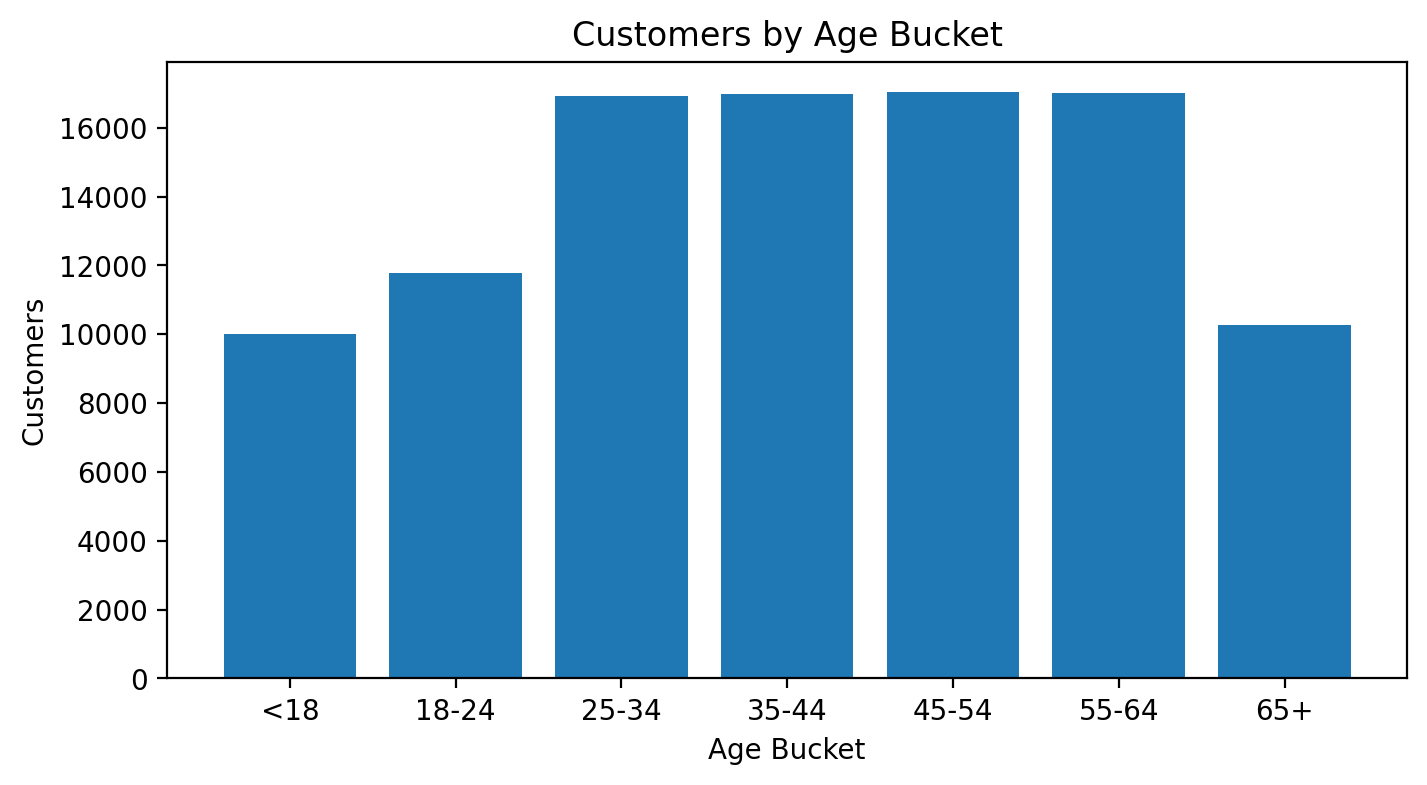

In [44]:
# ========= 2) Age buckets — robust DOB parsing (and plot) =========
def build_age_years(df):
    df = df.copy()
    # direct DOB-like columns
    dob_col = pick_first(detect_columns(df, ["dob","birth","birthday","date_of_birth"]))
    if dob_col:
        df[dob_col] = pd.to_datetime(df[dob_col], errors="coerce")
        age_years = ((pd.Timestamp.today() - df[dob_col]).dt.days/365.25)
        df["age_years"] = age_years
    
    # explicit age fields (if present)
    if "age_years" not in df.columns:
        age_col = pick_first(detect_columns(df, ["age_years","age"]))
        if age_col:
            df["age_years"] = pd.to_numeric(df[age_col], errors="coerce")
    
    # year/month/day split fields (birth_year, birth_month, birth_day)
    if "age_years" not in df.columns or df["age_years"].isna().all():
        y = pick_first(detect_columns(df, ["birth_year","yob","year_of_birth"]))
        m = pick_first(detect_columns(df, ["birth_month","mob","month_of_birth"]))
        d = pick_first(detect_columns(df, ["birth_day","dob_day","day_of_birth"]))
        if y:
            # approximate date (use 6/30 if month/day missing)
            yr = pd.to_numeric(df[y], errors="coerce")
            mo = pd.to_numeric(df[m], errors="coerce") if m else 6
            dy = pd.to_numeric(df[d], errors="coerce") if d else 15
            dob = pd.to_datetime(dict(year=yr, month=mo, day=dy), errors="coerce")
            df["age_years"] = ((pd.Timestamp.today() - dob).dt.days/365.25)
    return df

users = build_age_years(users)

if "age_years" in users.columns and users["age_years"].notna().any():
    bins = [0,18,25,35,45,55,65,120]
    labels = ["<18","18-24","25-34","35-44","45-54","55-64","65+"]
    users["age_bucket"] = pd.cut(users["age_years"], bins=bins, labels=labels, right=False, include_lowest=True)
    age_buckets = (users["age_bucket"]
                   .value_counts(dropna=False)
                   .rename_axis("age_bucket")
                   .reset_index(name="customers")
                   .sort_values("age_bucket"))
    print("\nCustomers by age bucket:")
    display(age_buckets)
    age_buckets.to_csv(os.path.join(OUT_DIR, "customers_by_age_bucket.csv"), index=False)

    fig = plt.figure(figsize=(8,4))
    plt.bar(age_buckets["age_bucket"].astype(str), age_buckets["customers"])
    plt.title("Customers by Age Bucket"); plt.xlabel("Age Bucket"); plt.ylabel("Customers")
    finish_fig(fig, "customers_by_age_bucket.png")
else:
    print("\nNo usable DOB/age fields detected to build age buckets.")


Order milestone coverage (% non-null):


,milestone,percent
0,created_at,100.00
1,paid_at,NaN
2,shipped_at,61.76
3,delivered_at,39.31
4,returned_at,7.51
5,canceled_at,NaN


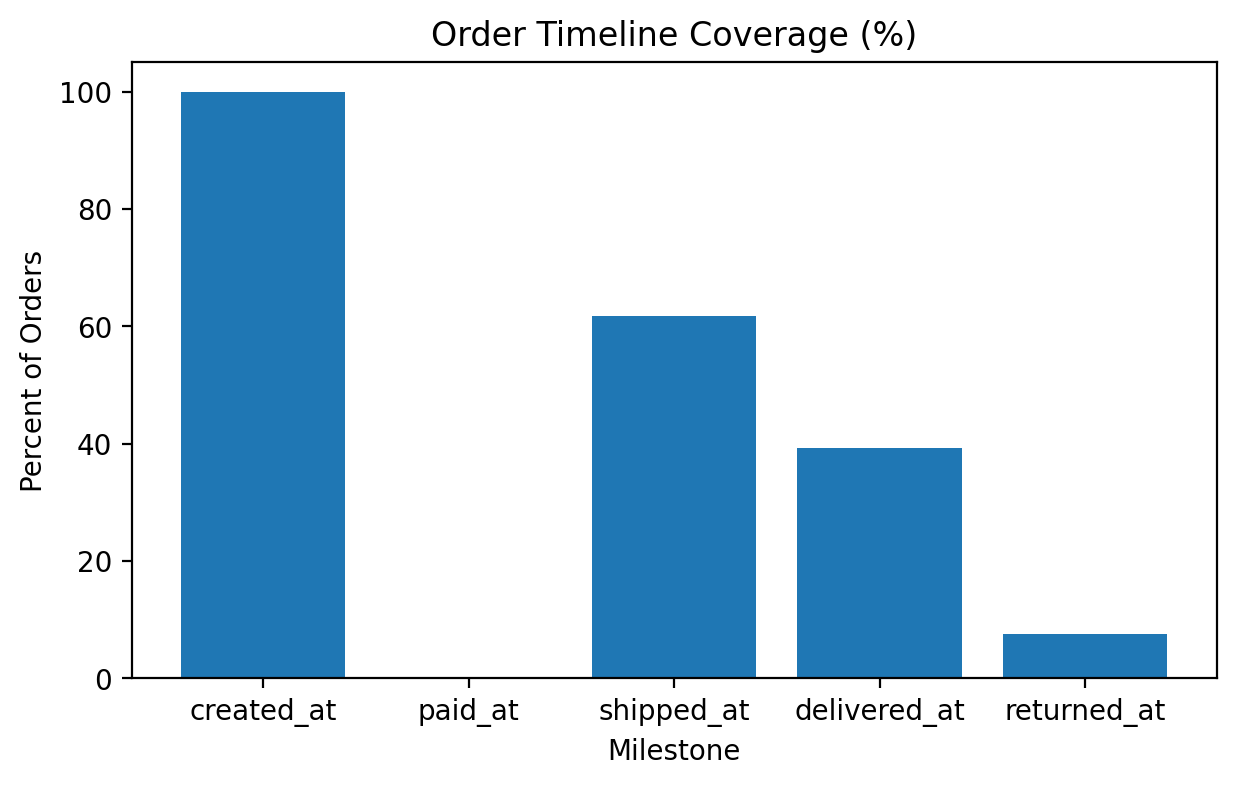


Latency summary (days):


,count,mean,std,min,50%,90%,95%,max
created_to_shipped_days,50937.0,1.50,0.87,0.0,1.50,2.70,2.85,3.0
shipped_to_delivered_days,32426.0,2.49,1.44,0.0,2.48,4.50,4.75,5.0
delivered_to_returned_days,6193.0,1.48,0.88,0.0,1.47,2.71,2.85,3.0


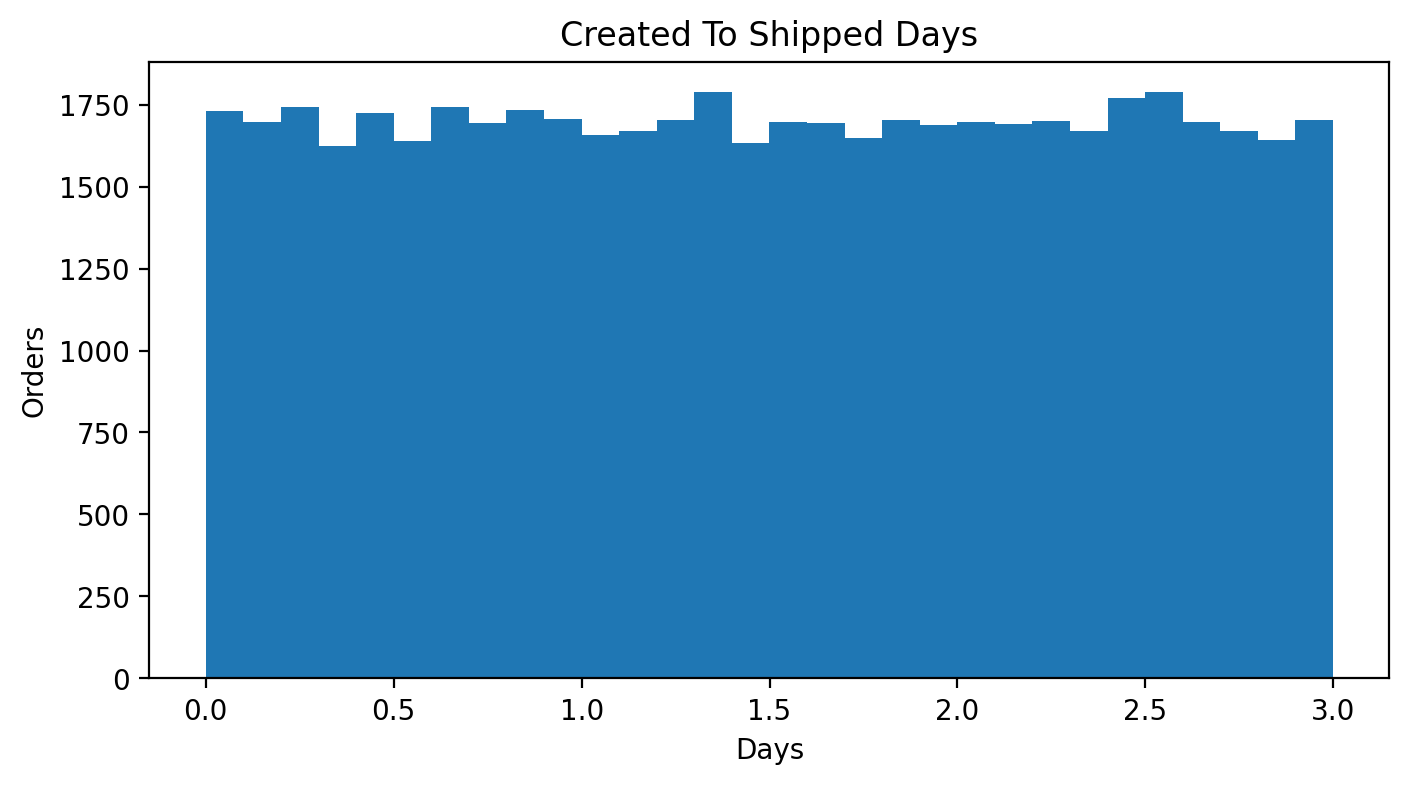

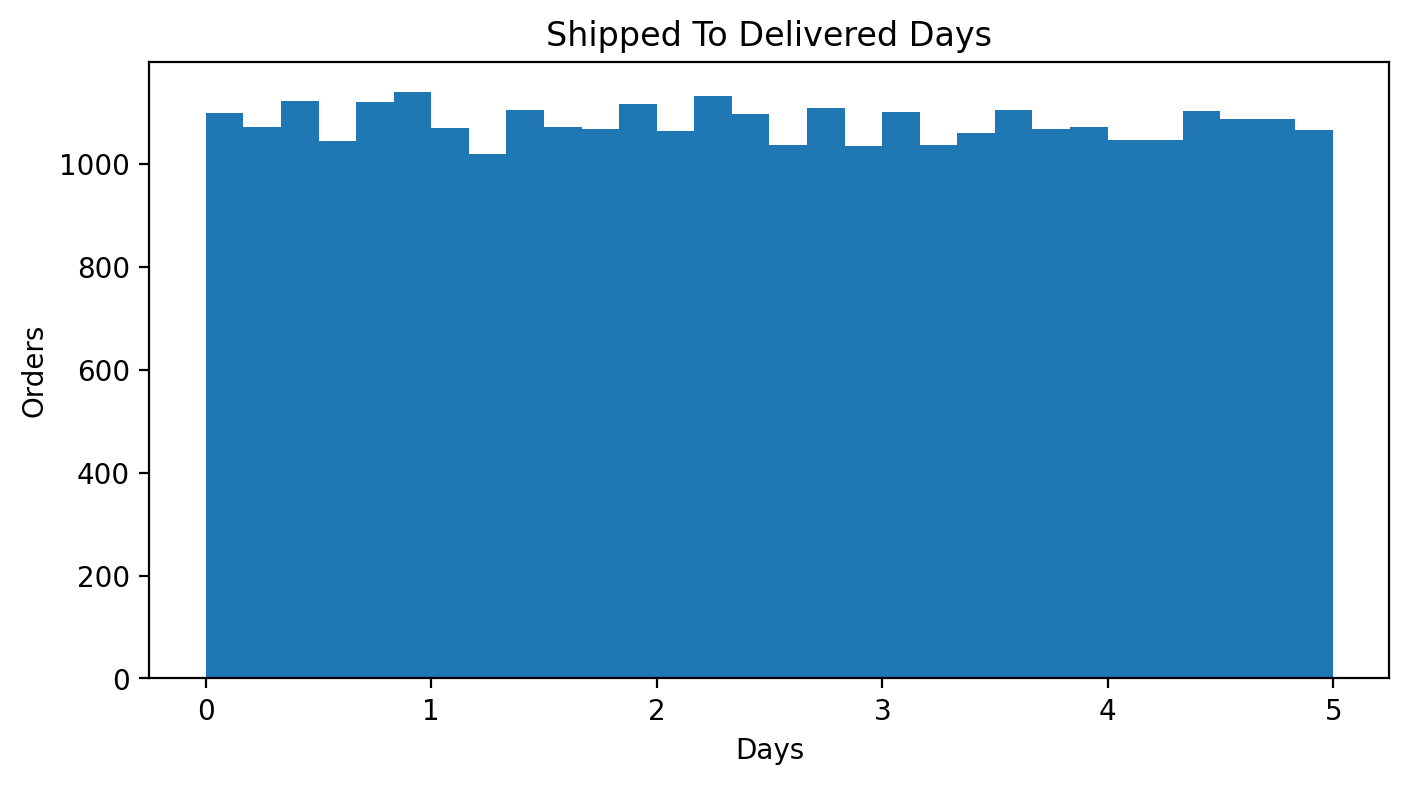

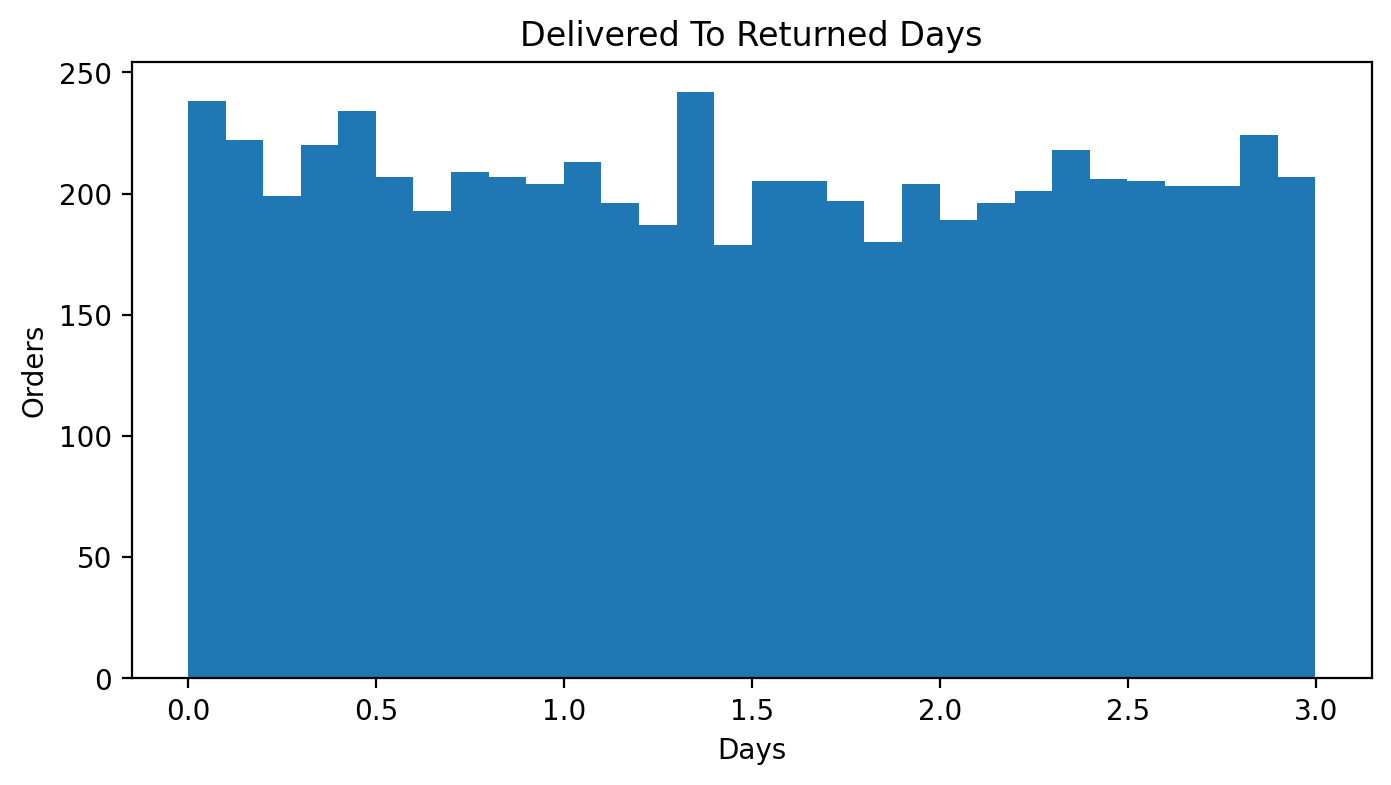


Order funnel:


,stage,count,pct_of_all_orders,seq_conversion_%
0,created,82480,100.00,NaN
1,shipped,50937,61.76,61.76
2,delivered,32426,39.31,63.66
3,returned,6193,7.51,19.10
4,canceled,0,0.00,0.00


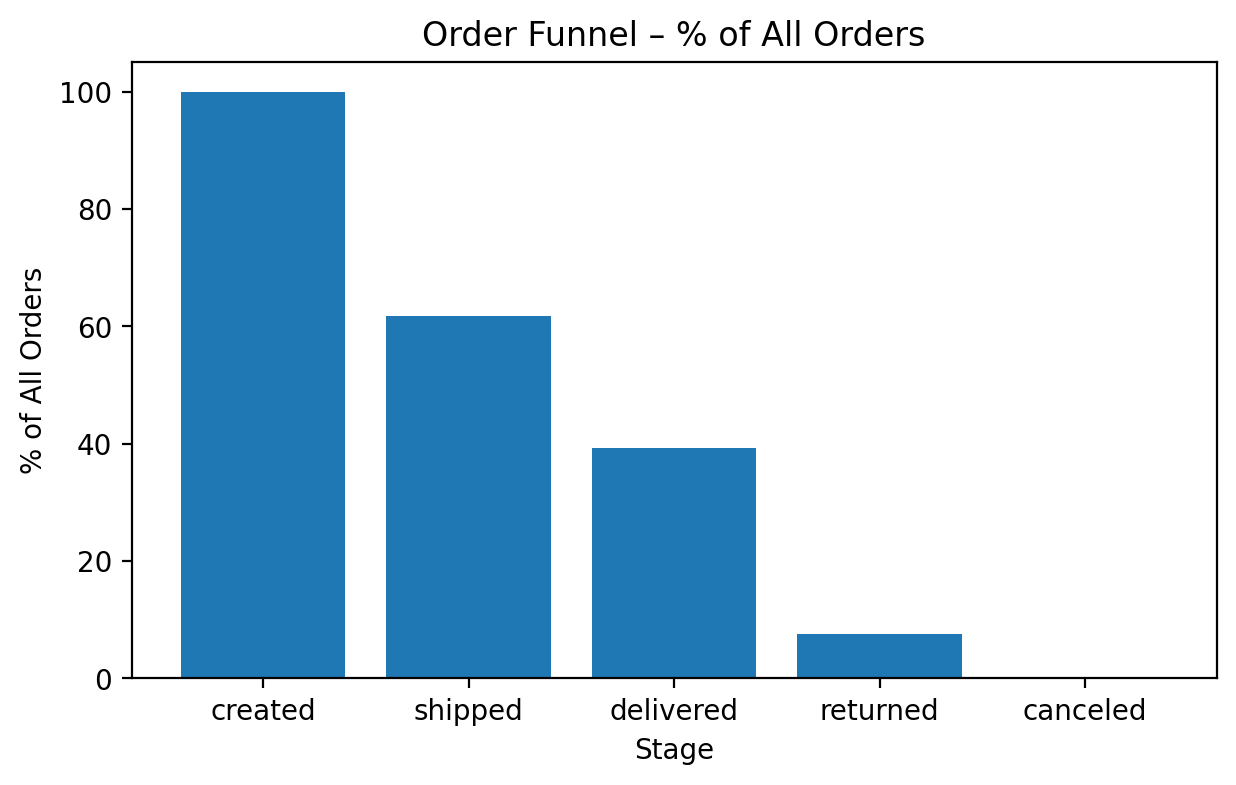

In [45]:
# detect time columns
event_map = {
    "created_at":   ["created_at","created","order_created","placed","ordered","order_date"],
    "paid_at":      ["paid_at","paid","payment_date"],
    "shipped_at":   ["shipped_at","shipped","ship_date","shipment_date"],
    "delivered_at": ["delivered_at","delivered","delivery_date"],
    "returned_at":  ["returned_at","returned","return_date","rma_date"],
    "canceled_at":  ["canceled_at","cancelled_at","cancelled","canceled","cancel_date"],
}
event_cols = {k: first_match(orders, v) for k,v in event_map.items()}

# ---- TZ normalization: parse EVERYTHING as UTC (tz-aware) so subtraction is safe ----
def to_dt_utc(s):
    return pd.to_datetime(s, errors="coerce", utc=True)

for k, col in event_cols.items():
    if col:
        orders[col] = to_dt_utc(orders[col])

# ---- Coverage table ----
def pct_non_null(df, col):
    return round(df[col].notna().mean()*100, 2) if col and col in df.columns else np.nan

coverage = pd.DataFrame({
    "milestone": list(event_cols.keys()),
    "percent":   [pct_non_null(orders, c) for c in event_cols.values()]
})
print("\nOrder milestone coverage (% non-null):")
display(coverage)
coverage.to_csv(os.path.join(OUT_DIR, "order_timeline_coverage_full.csv"), index=False)

fig = plt.figure(figsize=(7,4))
plt.bar(coverage["milestone"].astype(str), coverage["percent"])
plt.title("Order Timeline Coverage (%)"); plt.xlabel("Milestone"); plt.ylabel("Percent of Orders")
finish_fig(fig, "order_timeline_coverage_full.png")

# ---- Latencies (days) between key pairs (non-negative only) ----
pairs = [
    ("created_at","paid_at","created_to_paid_days"),
    ("created_at","shipped_at","created_to_shipped_days"),
    ("shipped_at","delivered_at","shipped_to_delivered_days"),
    ("delivered_at","returned_at","delivered_to_returned_days"),
    ("created_at","canceled_at","created_to_canceled_days"),
]

lat_cols = []
for a,b,name in pairs:
    A = event_cols.get(a); B = event_cols.get(b)
    if A and B:
        # Both series are tz-aware (UTC) now, subtraction is safe
        lat = (orders[B] - orders[A]) / pd.Timedelta(days=1)
        orders[name] = lat.where(lat >= 0)  # keep non-negative intervals
        lat_cols.append(name)

if lat_cols:
    lat_summary = orders[lat_cols].describe(percentiles=[0.5,0.9,0.95]).T.round(2)
    print("\nLatency summary (days):")
    display(lat_summary)
    lat_summary.to_csv(os.path.join(OUT_DIR, "order_latency_summary_full.csv"))

    # histogram for each latency
    for c in lat_cols:
        s = orders[c].dropna()
        if not s.empty:
            fig = plt.figure(figsize=(8,4))
            plt.hist(s, bins=30)
            plt.title(c.replace("_"," ").title())
            plt.xlabel("Days"); plt.ylabel("Orders")
            finish_fig(fig, f"hist_{c}.png")
else:
    print("\nNo usable timestamp pairs to compute latencies.")

# ---- Simple order funnel (created -> shipped -> delivered, plus returned/canceled) ----
created_col   = event_cols.get("created_at")
shipped_col   = event_cols.get("shipped_at")
delivered_col = event_cols.get("delivered_at")
returned_col  = event_cols.get("returned_at")
canceled_col  = event_cols.get("canceled_at")

N = len(orders)
n_created   = int(orders[created_col].notna().sum())   if created_col   else 0
n_shipped   = int(orders[shipped_col].notna().sum())   if shipped_col   else 0
n_delivered = int(orders[delivered_col].notna().sum()) if delivered_col else 0
n_returned  = int(orders[returned_col].notna().sum())  if returned_col  else 0
n_canceled  = int(orders[canceled_col].notna().sum())  if canceled_col  else 0

funnel = pd.DataFrame({
    "stage": ["created","shipped","delivered","returned","canceled"],
    "count": [n_created, n_shipped, n_delivered, n_returned, n_canceled],
})
funnel["pct_of_all_orders"] = (funnel["count"]/N*100).round(2)
# sequential conversion rates
funnel["seq_conversion_%"] = [
    np.nan,
    round((n_shipped / n_created * 100), 2) if n_created else np.nan,
    round((n_delivered / n_shipped * 100), 2) if n_shipped else np.nan,
    round((n_returned / n_delivered * 100), 2) if n_delivered else np.nan,
    round((n_canceled / n_created * 100), 2) if n_created else np.nan,
]
print("\nOrder funnel:")
display(funnel)
funnel.to_csv(os.path.join(OUT_DIR, "order_funnel.csv"), index=False)

# quick bar for pct_of_all_orders
fig = plt.figure(figsize=(7,4))
plt.bar(funnel["stage"], funnel["pct_of_all_orders"])
plt.title("Order Funnel – % of All Orders")
plt.xlabel("Stage"); plt.ylabel("% of All Orders")
finish_fig(fig, "order_funnel_pct_of_all.png")

,country,customers
0,China,34005
1,United States,22343
2,Brasil,14582
3,South Korea,5338
4,France,4774
5,United Kingdom,4669
6,Germany,4145
7,Spain,4045
8,Japan,2424
9,Australia,2227


,country,revenue
3,China,277027.169338
13,United States,181994.589525
2,Brasil,120064.839712
10,South Korea,44942.639891
6,France,39523.749901
12,United Kingdom,36888.449899
11,Spain,34069.949890
7,Germany,33978.139893
8,Japan,19612.479958
0,Australia,17912.309955


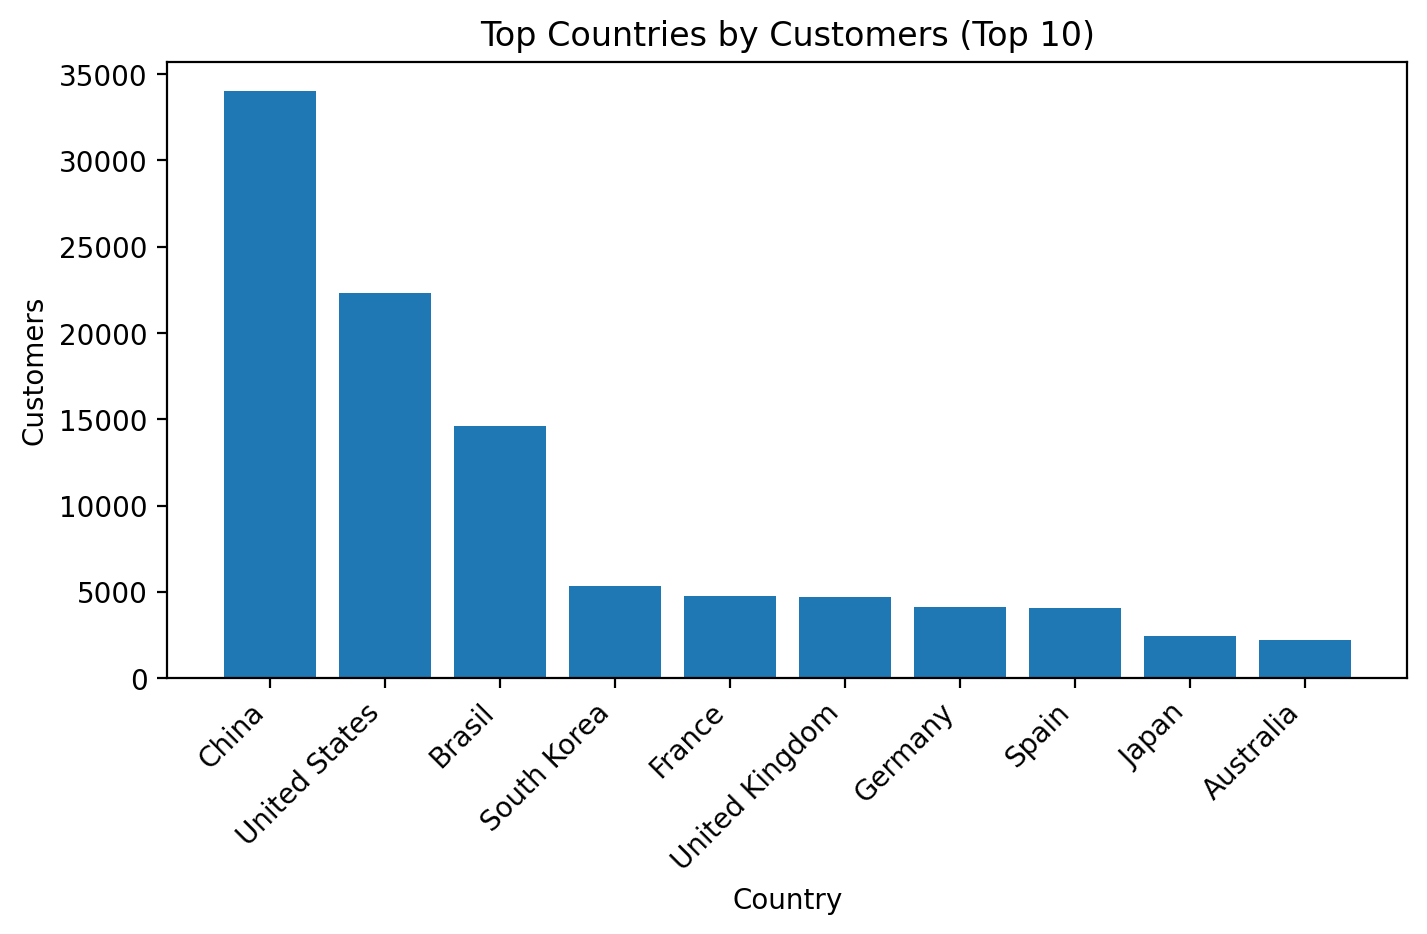

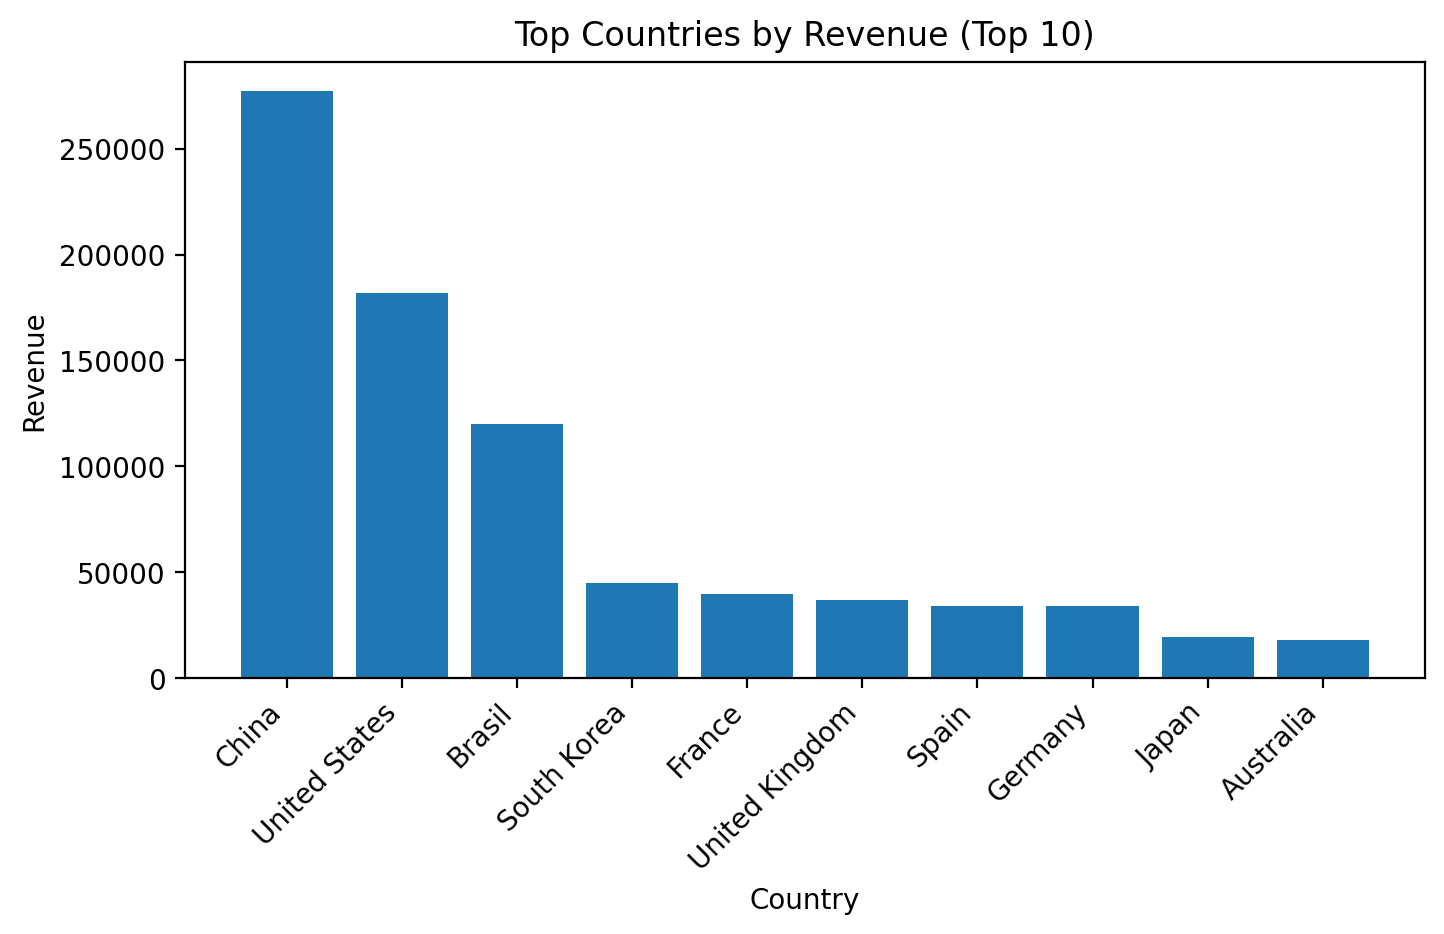

In [46]:
# ==================================================================================
# 4) Country: most customers & most sales (+ charts)
# ==================================================================================
country_col = pick_first(detect_columns(users, ["country","country_code","nation","geo_country"]))
if country_col:
    cust_by_country = users[country_col].value_counts(dropna=False).rename_axis(country_col).reset_index(name="customers")
    display(cust_by_country.head(20))
    cust_by_country.to_csv(os.path.join(OUT_DIR, "customers_by_country.csv"), index=False)

    if order_user_fk and user_id and user_id in users.columns:
        ou_geo = orders_users.merge(users[[user_id, country_col]], left_on=order_user_fk, right_on=user_id, how="left")
        ou_geo["order_revenue"] = pd.to_numeric(ou_geo["order_revenue"], errors="coerce").fillna(0)
        sales_by_country = ou_geo.groupby(country_col)["order_revenue"].sum().reset_index(name="revenue").sort_values("revenue", ascending=False)
        display(sales_by_country.head(20))
        sales_by_country.to_csv(os.path.join(OUT_DIR, "revenue_by_country.csv"), index=False)
    else:
        sales_by_country = pd.DataFrame(columns=[country_col,"revenue"])

    if not cust_by_country.empty:
        fig = plt.figure(figsize=(8,4))
        head = cust_by_country.head(10)
        plt.bar(head[country_col].astype(str), head["customers"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top Countries by Customers (Top 10)")
        plt.xlabel("Country"); plt.ylabel("Customers")
        finish_fig(fig, "top_countries_customers.png")

    if not sales_by_country.empty:
        fig = plt.figure(figsize=(8,4))
        head = sales_by_country.head(10)
        plt.bar(head[country_col].astype(str), head["revenue"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top Countries by Revenue (Top 10)")
        plt.xlabel("Country"); plt.ylabel("Revenue")
        finish_fig(fig, "top_countries_revenue.png")

,age_bucket,customers
6,<18,10006
4,18-24,11783
3,25-34,16925
2,35-44,16967
0,45-54,17044
1,55-64,17001
5,65+,10274


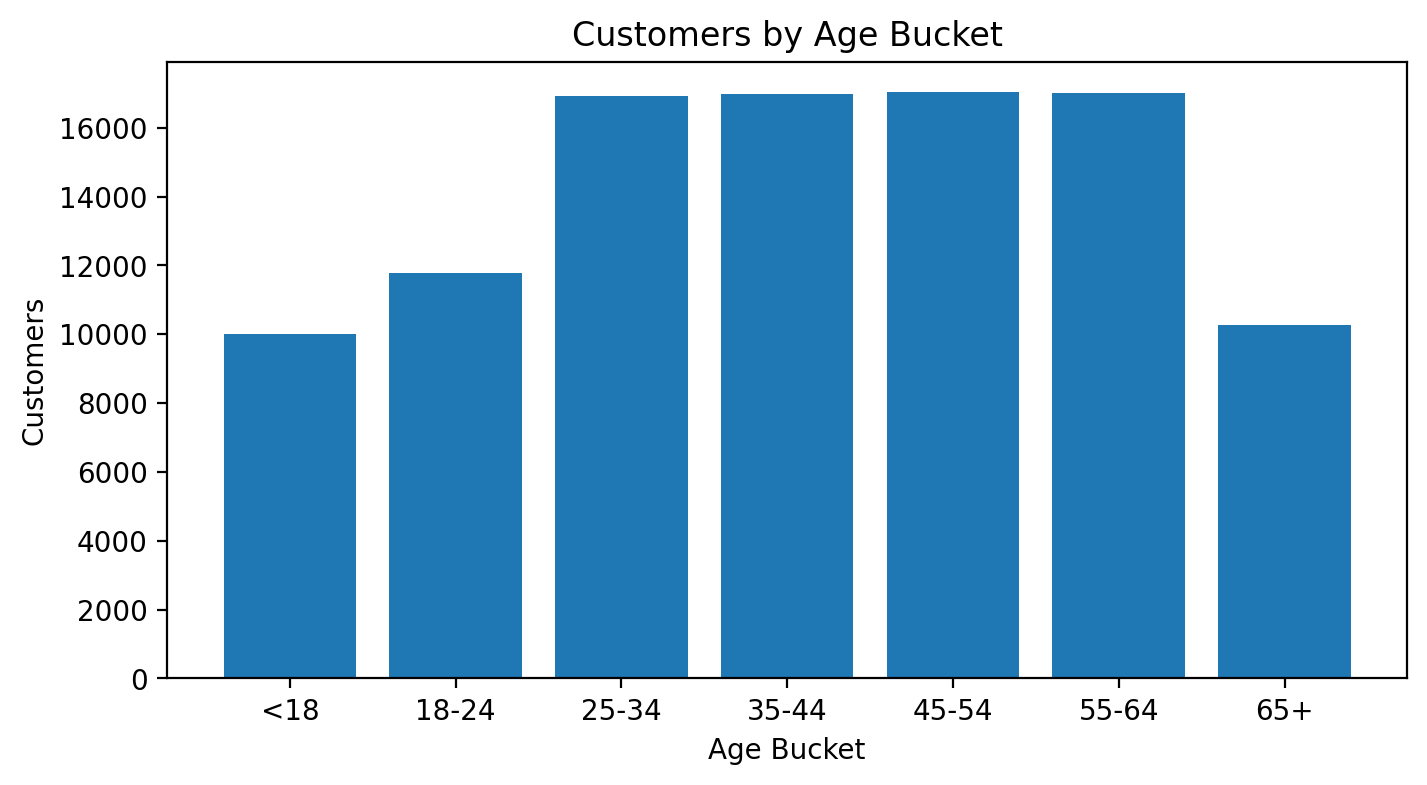

In [47]:
# ==================================================================================
# 5) Gender split & age buckets (+ charts)
# ==================================================================================
# gender_col = pick_first(detect_columns(users, ["gender","sex"]))
# if gender_col:
#     gender_counts = users[gender_col].value_counts(dropna=False).rename_axis(gender_col).reset_index(name="customers")
#     display(gender_counts)
#     gender_counts.to_csv(os.path.join(OUT_DIR, "customers_by_gender.csv"), index=False)

#     fig = plt.figure(figsize=(6,4))
#     plt.bar(gender_counts[gender_col].astype(str), gender_counts["customers"])
#     plt.title("Customers by Gender"); plt.xlabel("Gender"); plt.ylabel("Customers")
#     finish_fig(fig, "customers_by_gender.png")

# Age buckets (if DOB present)
dob_col = pick_first(detect_columns(users, ["dob","birth","birthday","date_of_birth"]))
if dob_col:
    users[dob_col] = pd.to_datetime(users[dob_col], errors="coerce")
    ref = pd.Timestamp.today()
    users["age_years"] = ((ref - users[dob_col]).dt.days/365.25)

if "age_years" in users.columns and users["age_years"].notna().any():
    bins = [0,18,25,35,45,55,65,120]
    labels = ["<18","18-24","25-34","35-44","45-54","55-64","65+"]
    users["age_bucket"] = pd.cut(users["age_years"], bins=bins, labels=labels, right=False, include_lowest=True)
    age_buckets = (users["age_bucket"].value_counts(dropna=False)
                   .rename_axis("age_bucket").reset_index(name="customers")
                   .sort_values("age_bucket"))
    display(age_buckets)
    age_buckets.to_csv(os.path.join(OUT_DIR, "customers_by_age_bucket.csv"), index=False)

    fig = plt.figure(figsize=(8,4))
    plt.bar(age_buckets["age_bucket"].astype(str), age_buckets["customers"])
    plt.title("Customers by Age Bucket"); plt.xlabel("Age Bucket"); plt.ylabel("Customers")
    finish_fig(fig, "customers_by_age_bucket.png")


In [48]:
# ==================================================================================
# 6) Category mix (revenue & quantity) + chart
# ==================================================================================
cat_col = pick_first([c for c in products.columns if any(x in c for x in ["category","cat","department","segment"])], default=None)
if cat_col and product_id and product_id in products.columns and oi_product_id and oi_product_id in oi_enriched.columns:
    cat_items = oi_enriched.merge(products[[product_id, cat_col]], left_on=oi_product_id, right_on=product_id, how="left")

    cat_rev = (cat_items.groupby(cat_col)["__line_revenue"].sum(min_count=1)
               .reset_index(name="revenue").sort_values("revenue", ascending=False))
    cat_qty = (cat_items.groupby(cat_col)[oi_qty].sum(min_count=1)
               .reset_index(name="quantity").sort_values("quantity", ascending=False))

    display(cat_rev.head(20)); display(cat_qty.head(20))
    cat_rev.to_csv(os.path.join(OUT_DIR, "categories_by_revenue.csv"), index=False)
    cat_qty.to_csv(os.path.join(OUT_DIR, "categories_by_quantity.csv"), index=False)

    if not cat_rev.empty:
        fig = plt.figure(figsize=(10,4.5))
        head = cat_rev.head(10)
        plt.bar(head[cat_col].astype(str), head["revenue"])
        plt.xticks(rotation=45, ha="right")
        plt.title("Top Categories by Revenue (Top 10)")
        plt.xlabel("Category"); plt.ylabel("Revenue")
        finish_fig(fig, "top_categories_revenue.png")

print("✔ Plots & CSVs saved under:", OUT_DIR)

KeyError: 'Column not found: __line_revenue'

# How can we boost customer loyalty and accelerate sales?

### Customer segmentation: idenify distinct customer segments based on purchasing behavior, demographics, or engagment? What are the characteristics of your most valuable or most at-risk customers?

RFM + AOV + Tenure (per customer)

Recency (recency_days)
Days since the customer’s most recent order.
Formula: recency_days = (as_of_date - last_order_date).days
Smaller is better (more recent activity).

Frequency (frequency)
Number of distinct orders in the window (not items).
Formula: frequency = count_distinct(order_id)
(Optional) normalize to time: orders_per_month = frequency / max(tenure_months, 1/30).

Monetary (monetary)
Total customer spend in the window. Use net revenue (after discounts/refunds), usually exclude tax & shipping.
Formula: monetary = sum(order_revenue).

Average Order Value (aov)
Average dollars per order.
Formula: aov = monetary / frequency (define as NA or 0 if frequency = 0).

Tenure (tenure_days)
Customer “age” with you: days since their first order up to the snapshot.
Formula: tenure_days = (as_of_date - first_order_date).days
(Alternate metric some teams use: engagement span = last_order_date − first_order_date.)

In [49]:
# ---- keys/columns ----
user_id     = pick_first(detect_columns(users,   ["user_id","id"]))
product_id  = pick_first(detect_columns(products,["product_id","id"]))
order_id    = pick_first(detect_columns(orders,  ["order_id","id"]))
order_user_fk = pick_first(detect_columns(orders, ["user_id","customer_id","buyer_id","account_id"]))

# Order date (tz-safe)
order_date_col = first_match(orders, ["order_date","created_at","created","placed","ordered","timestamp","time"])
orders[order_date_col] = pd.to_datetime(orders[order_date_col], errors="coerce", utc=True)

# Ensure we have order_revenue on orders; if not, build from order_items
if "order_revenue" not in orders.columns or orders["order_revenue"].isna().all():
    oi_order_id   = pick_first(detect_columns(order_items, ["order_id"]))
    oi_qty        = pick_first(detect_columns(order_items, ["num_of_item","num_of_items","quantity","qty","item_count","items_count","count","units"]))
    oi_price      = pick_first(detect_columns(order_items, ["unit_price","price","amount","list_price"]))
    oi_subtotal   = pick_first(detect_columns(order_items, ["subtotal","line_total","extended_price","total","amount"]))
    if oi_qty is None:
        order_items["__qty"] = 1.0; oi_qty = "__qty"
    else:
        order_items[oi_qty] = pd.to_numeric(order_items[oi_qty], errors="coerce").fillna(1.0)
    if oi_price and oi_price in order_items.columns:
        order_items["__line_revenue"] = pd.to_numeric(order_items[oi_price], errors="coerce").fillna(0) * pd.to_numeric(order_items[oi_qty], errors="coerce").fillna(0)
    elif oi_subtotal and oi_subtotal in order_items.columns:
        order_items["__line_revenue"] = pd.to_numeric(order_items[oi_subtotal], errors="coerce").fillna(0)
    else:
        order_items["__line_revenue"] = 0.0
    if oi_order_id:
        order_agg = order_items.groupby(oi_order_id, as_index=False)["__line_revenue"].sum().rename(columns={"__line_revenue":"order_revenue"})
        orders = orders.merge(order_agg, left_on=order_id, right_on=oi_order_id, how="left")

# ---- Build orders_users with a readable display (email/name if present) ----
user_display = pick_first([c for c in users.columns if any(x in c for x in ["email","name","full_name","username"])], default=user_id)
orders_users = orders.copy()
if order_user_fk and user_id and user_id in users.columns:
    orders_users = orders_users.merge(users[[user_id, user_display]], left_on=order_user_fk, right_on=user_id, how="left")


In [50]:
# =========================
# 1) RFM features + segment labels
# =========================

# Build a minimal orders table with customer id, order id, order date, order revenue.
#   - This is the raw material for R (Recency), F (Frequency), M (Monetary), AOV, and Tenure.
ou = orders_users[[order_user_fk, order_id, order_date_col, "order_revenue"]].copy()

# Standardize types:
#   - Dates -> datetime (UTC) so we can do time math
#   - Revenue -> numeric (NaNs -> 0) so sums work
ou[order_date_col] = pd.to_datetime(ou[order_date_col], errors="coerce", utc=True)
ou["order_revenue"] = pd.to_numeric(ou["order_revenue"], errors="coerce").fillna(0)

# Keep only rows that have a valid customer id + order date
ou = ou.dropna(subset=[order_user_fk, order_date_col])

# Choose a snapshot ("as_of") date to measure recency/tenure relative to.
# Here we use 1 day after the last observed order.
#   - Recency (days since last order) = as_of - last_order_date
#   - Tenure  (days since first order) = as_of - first_order_date
ref_date = ou[order_date_col].max() + pd.Timedelta(days=1)

# Collapse to customer level:
#   - first/last order dates → Tenure & Recency anchors
#   - frequency = # distinct orders
#   - monetary  = total spend
cust = (ou.groupby(order_user_fk, as_index=False)
          .agg(first_order_date=(order_date_col,"min"),
               last_order_date=(order_date_col,"max"),
               frequency=(order_id,"nunique"),
               monetary=("order_revenue","sum")))

# R & T in days (smaller recency is "better"/more active; larger tenure means longer relationship)
cust["recency_days"] = (ref_date - cust["last_order_date"]).dt.total_seconds()/86400.0
cust["tenure_days"]  = (ref_date - cust["first_order_date"]).dt.total_seconds()/86400.0

# AOV = Monetary / Frequency (average spend per order)
# Safe-divide: if frequency were ever 0, return NaN
cust["aov"] = cust["monetary"] / cust["frequency"].replace(0, np.nan)

# ---------- Interpurchase cadence (for churn risk later) ----------
# Per-customer median time between consecutive orders (days).
# This captures "typical buying cycle" so we can set a personalized churn window.
def median_ip(g):
    s = g.sort_values(order_date_col)[order_date_col].values
    if len(s) < 2: return np.nan
    diffs = np.diff(s).astype("timedelta64[D]").astype(float)  # consecutive gaps in days
    return float(np.median(diffs))

ip = (ou.groupby(order_user_fk)
        .apply(median_ip)
        .rename("interpurchase_median_days")
        .reset_index())

# Combine core RFM table with cadence feature
rfm = cust.merge(ip, on=order_user_fk, how="left")

# ---------- Quintile-based R/F/M scores (1..5) ----------
# We convert raw Recency/Frequency/Monetary to ordinal scores:
#   - Recency: lower days ⇒ higher score (invert)
#   - Frequency: more orders ⇒ higher score
#   - Monetary: more spend  ⇒ higher score
# Each score uses quintiles to place customers relative to peers.
def quintile_scores(series, higher=True):
    s = pd.Series(series).astype(float)
    # Precompute the 20/40/60/80% cut points on non-null values
    q = s.dropna().quantile([0.2,0.4,0.6,0.8]).values if s.dropna().size else [0,0,0,0]
    out = []
    for v in s:
        if np.isnan(v):
            out.append(3)  # neutral score when value is missing
            continue
        # Count how many thresholds v exceeds (0..4), then map to 1..5
        passed = sum(v > q[:i+1][-1] for i in range(4))
        if higher:
            out.append(1 + passed)      # higher values should get higher scores
        else:
            out.append(5 - passed)      # lower values should get higher scores (e.g., Recency)
    return pd.Series(out, index=s.index)

# Apply scoring:
rfm["r_score"] = quintile_scores(rfm["recency_days"], higher=False)  # smaller recency ⇒ bigger score
rfm["f_score"] = quintile_scores(rfm["frequency"],   higher=True)
rfm["m_score"] = quintile_scores(rfm["monetary"],    higher=True)

# Aggregate RFM score if you want a single rank-like metric
rfm["rfm_sum"] = rfm[["r_score","f_score","m_score"]].sum(axis=1)

# ---------- Simple rule-based segmentation ----------
# These labels illustrate how you'd translate RFM scores into business personas:
#   - VIP: high R (recent), F, and M
#   - Loyal: very recent + strong in either F or M
#   - Potential Loyalist: mid-to-high recency & frequency
#   - Dormant: low on all three
#   - At Risk: poor recency but historically decent F or M
#   - Regulars: everyone else
def seg_label(r,f,m):
    if r>=4 and f>=4 and m>=4: return "VIP"
    if r>=4 and (f>=4 or m>=4): return "Loyal"
    if r>=3 and f>=3:           return "Potential Loyalist"
    if r<=2 and f<=2 and m<=2:  return "Dormant"
    if r<=2 and (f>=3 or m>=3): return "At Risk"
    return "Regulars"

rfm["segment"] = [seg_label(r,f,m) for r,f,m in rfm[["r_score","f_score","m_score"]].to_numpy()]

# ---------- Personalized churn window & risk flags ----------
# Use each customer's median interpurchase interval (IP) to set a "churn window".
# Idea: if a customer usually buys every ~X days, consider them churned when they pass ~2X without buying.
# We also clamp the window to [30, 180] days to prevent extreme thresholds for very sparse or very frequent buyers.
global_median_ip = float(np.nanmedian(rfm["interpurchase_median_days"])) if rfm["interpurchase_median_days"].notna().any() else 45.0
rfm["churn_window_days"] = np.clip(
    rfm["interpurchase_median_days"].fillna(global_median_ip) * 2.0,  # 2× typical cycle
    30, 180
)

# Flags:
#   - is_churned: recency exceeds the personalized churn window
#   - is_at_risk: within the last 25% of that window (i.e., getting close to churn)
rfm["is_churned"] = rfm["recency_days"] > rfm["churn_window_days"]
rfm["is_at_risk"] = (~rfm["is_churned"]) & (rfm["recency_days"] > 0.75 * rfm["churn_window_days"])


Text(0.5, 0, 'Segment')

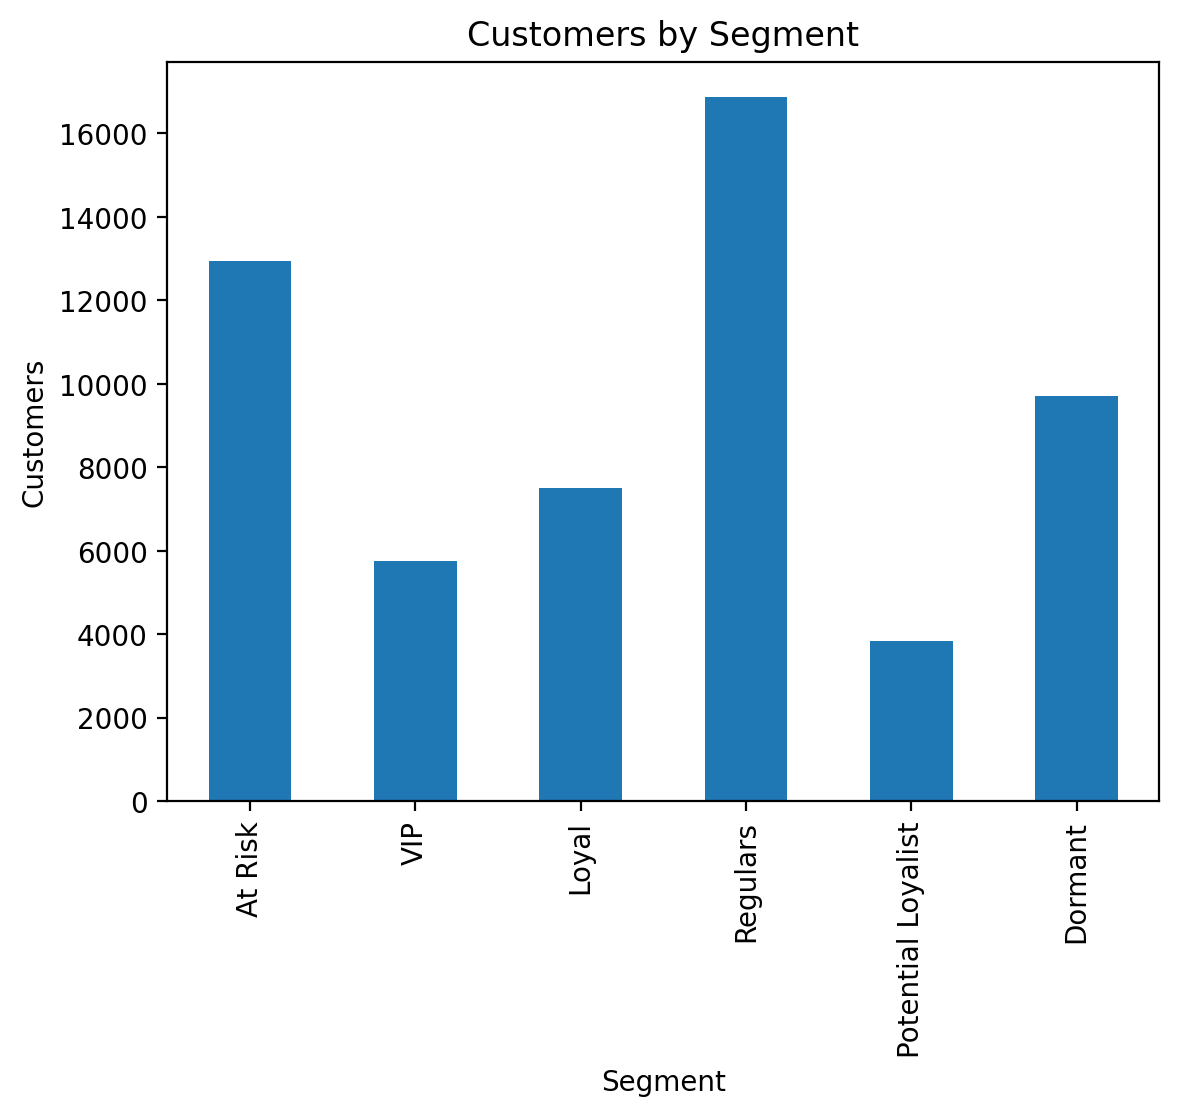

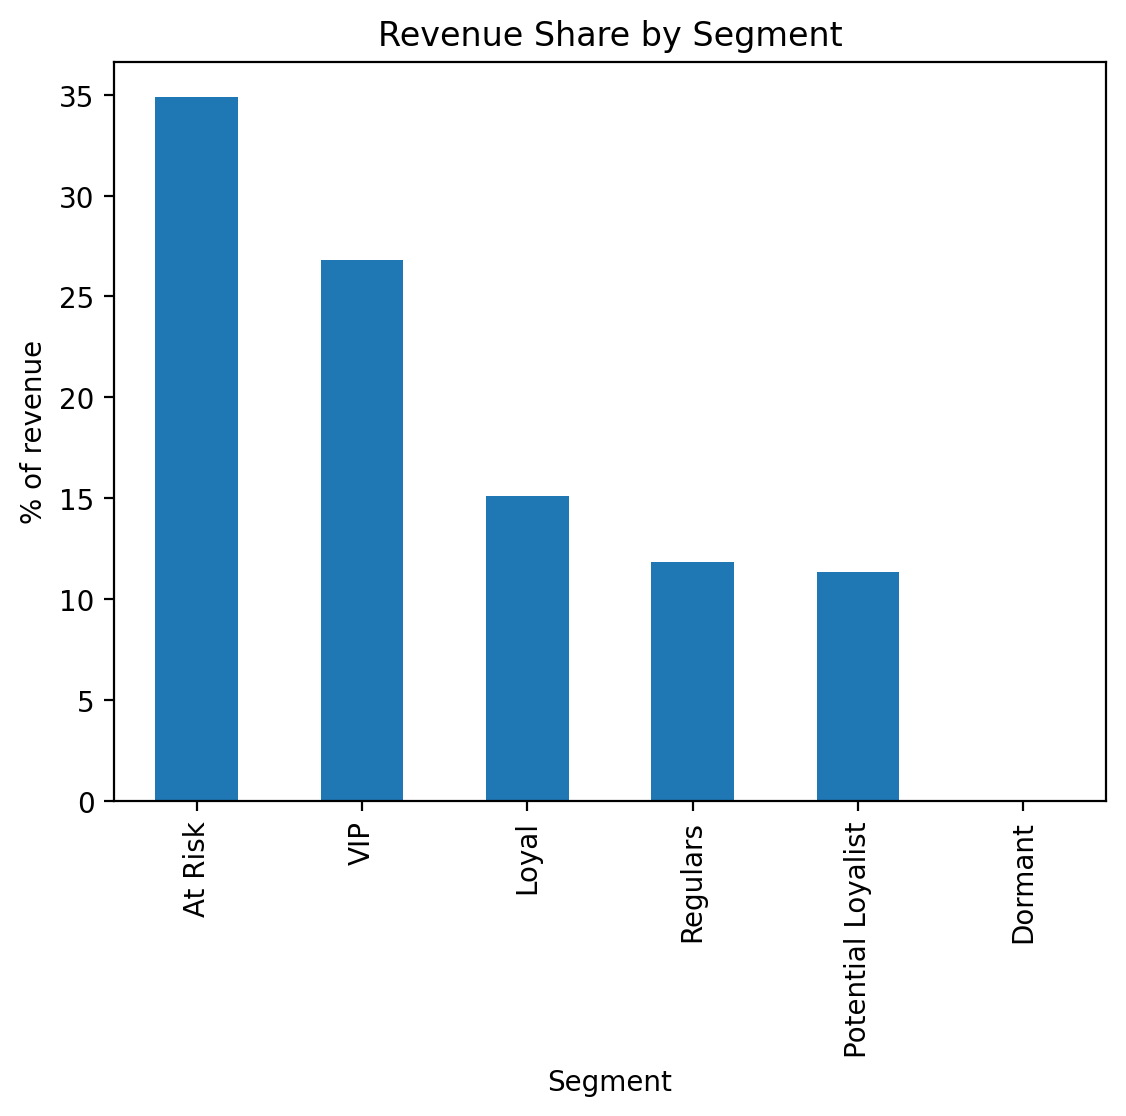

In [51]:
# 1) Segment size & revenue share
seg_orders = orders_users.merge(rfm[[order_user_fk, "segment"]], on=order_user_fk, how="left")
seg_rev = seg_orders.groupby("segment")["order_revenue"].sum().sort_values(ascending=False)
seg_cnt = rfm["segment"].value_counts().reindex(seg_rev.index)

plt.figure()
seg_cnt.plot(kind="bar")
plt.title("Customers by Segment"); plt.ylabel("Customers"); plt.xlabel("Segment")

plt.figure()
(seg_rev / seg_rev.sum() * 100).plot(kind="bar")
plt.title("Revenue Share by Segment"); plt.ylabel("% of revenue"); plt.xlabel("Segment")

Text(0.5, 1.0, 'Avg Monetary by Frequency & Recency bins')

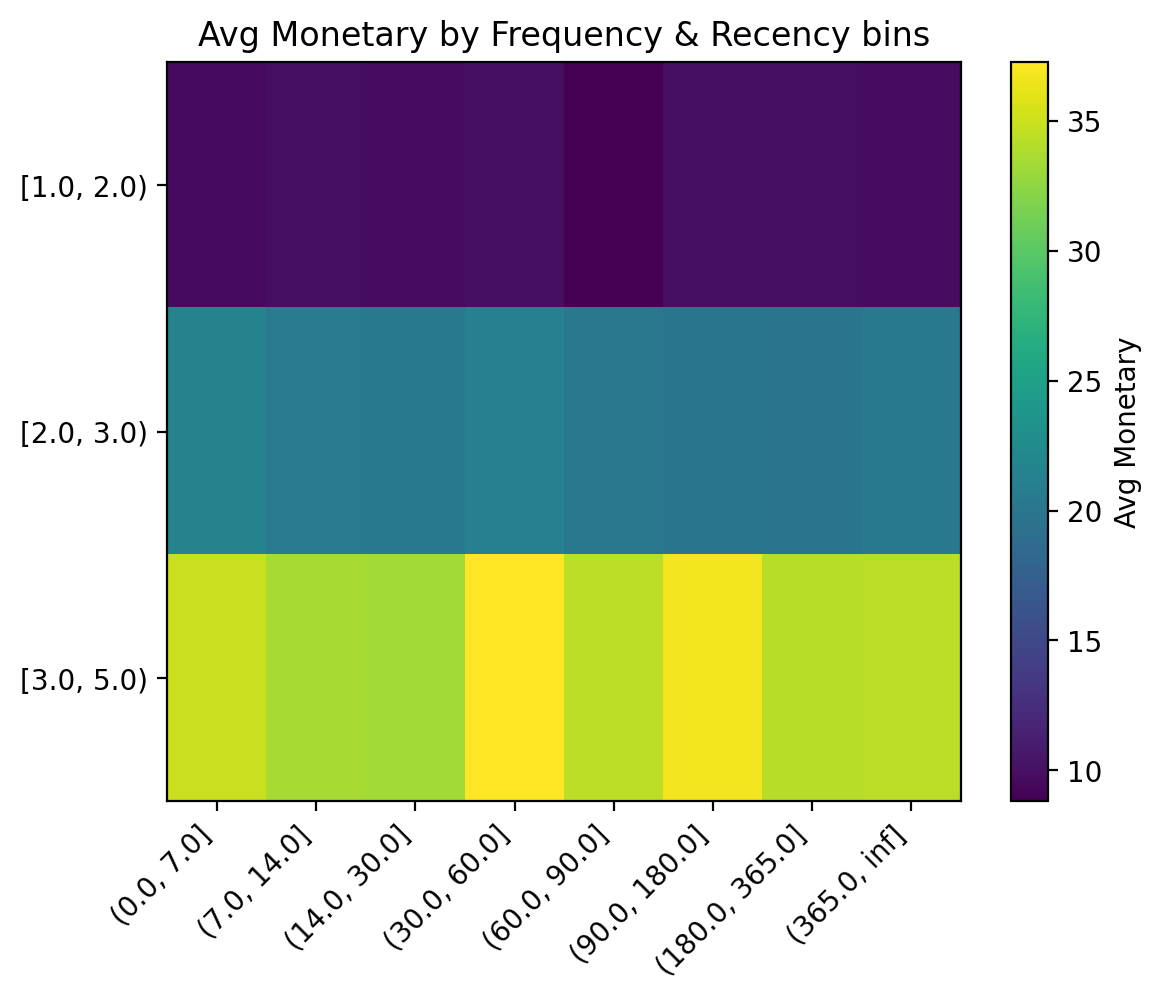

In [52]:
#3) R×F heatmap of Avg Monetary
r_bins = [0,7,14,30,60,90,180,365, np.inf]
f_bins = [1,2,3,5,8,13,21, np.inf]
tmp = rfm.copy()
tmp["r_bin"] = pd.cut(tmp["recency_days"], r_bins, right=True)
tmp["f_bin"] = pd.cut(tmp["frequency"], f_bins, right=False)
heat = tmp.pivot_table(index="f_bin", columns="r_bin", values="monetary", aggfunc="mean")

plt.figure()
plt.imshow(heat, aspect="auto")
plt.xticks(range(len(heat.columns)), [str(c) for c in heat.columns], rotation=45, ha="right")
plt.yticks(range(len(heat.index)), [str(i) for i in heat.index])
plt.colorbar(label="Avg Monetary")
plt.title("Avg Monetary by Frequency & Recency bins")

Text(0, 0.5, 'Total Monetary')

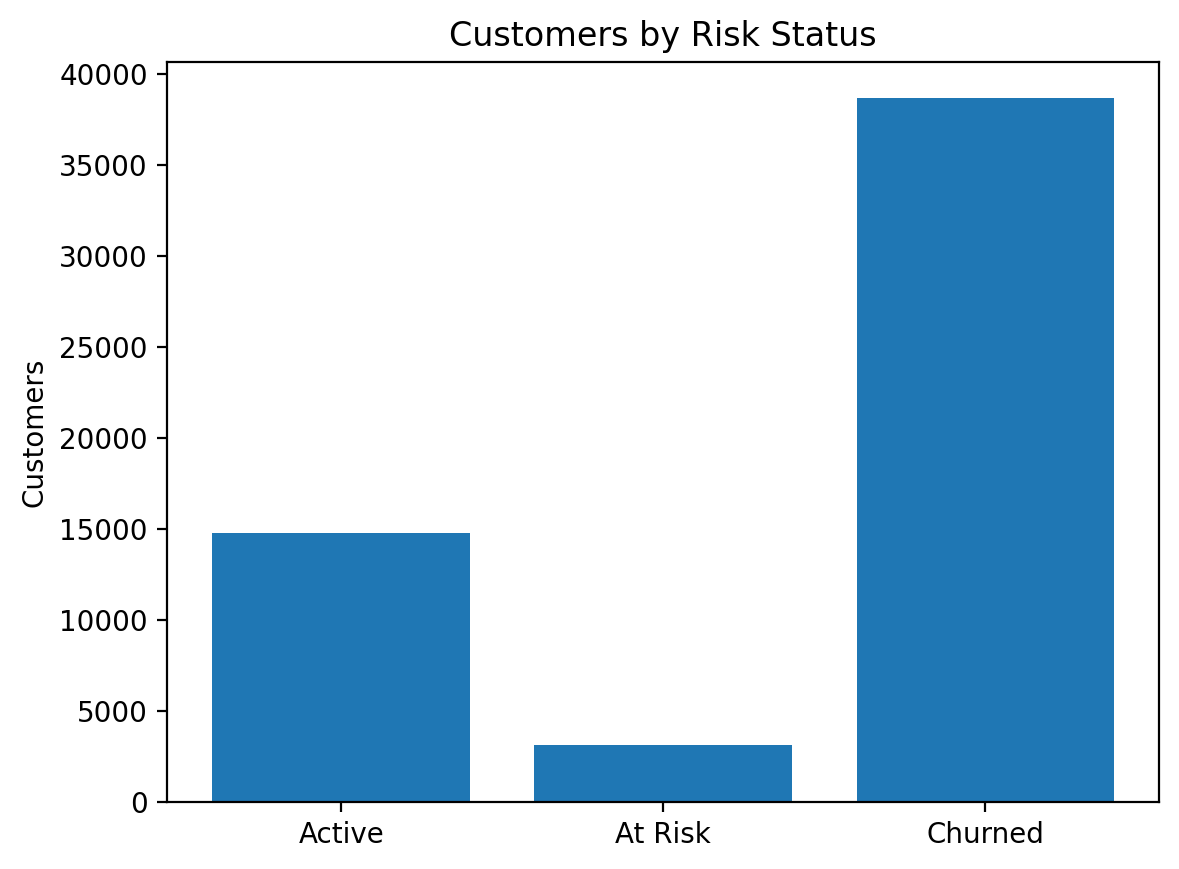

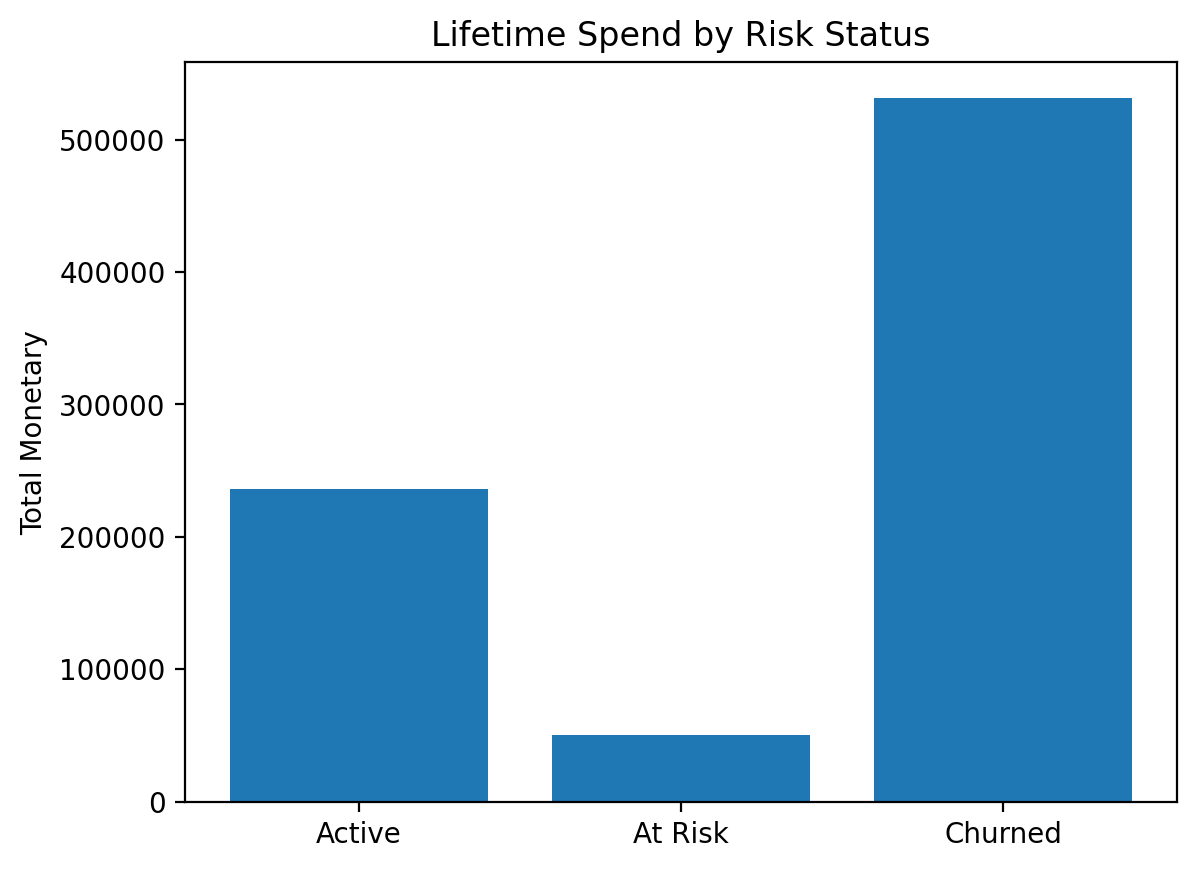

In [53]:
# 4) Risk funnel (Active / At Risk / Churned)
status = np.select([rfm["is_churned"], rfm["is_at_risk"]], ["Churned","At Risk"], default="Active")
risk = (rfm.assign(status=status)
          .groupby("status")
          .agg(customers=(order_user_fk, "count"), value=("monetary","sum"))
          .reindex(["Active","At Risk","Churned"]))

plt.figure()
plt.bar(risk.index, risk["customers"])
plt.title("Customers by Risk Status"); plt.ylabel("Customers")

plt.figure()
plt.bar(risk.index, risk["value"])
plt.title("Lifetime Spend by Risk Status"); plt.ylabel("Total Monetary")

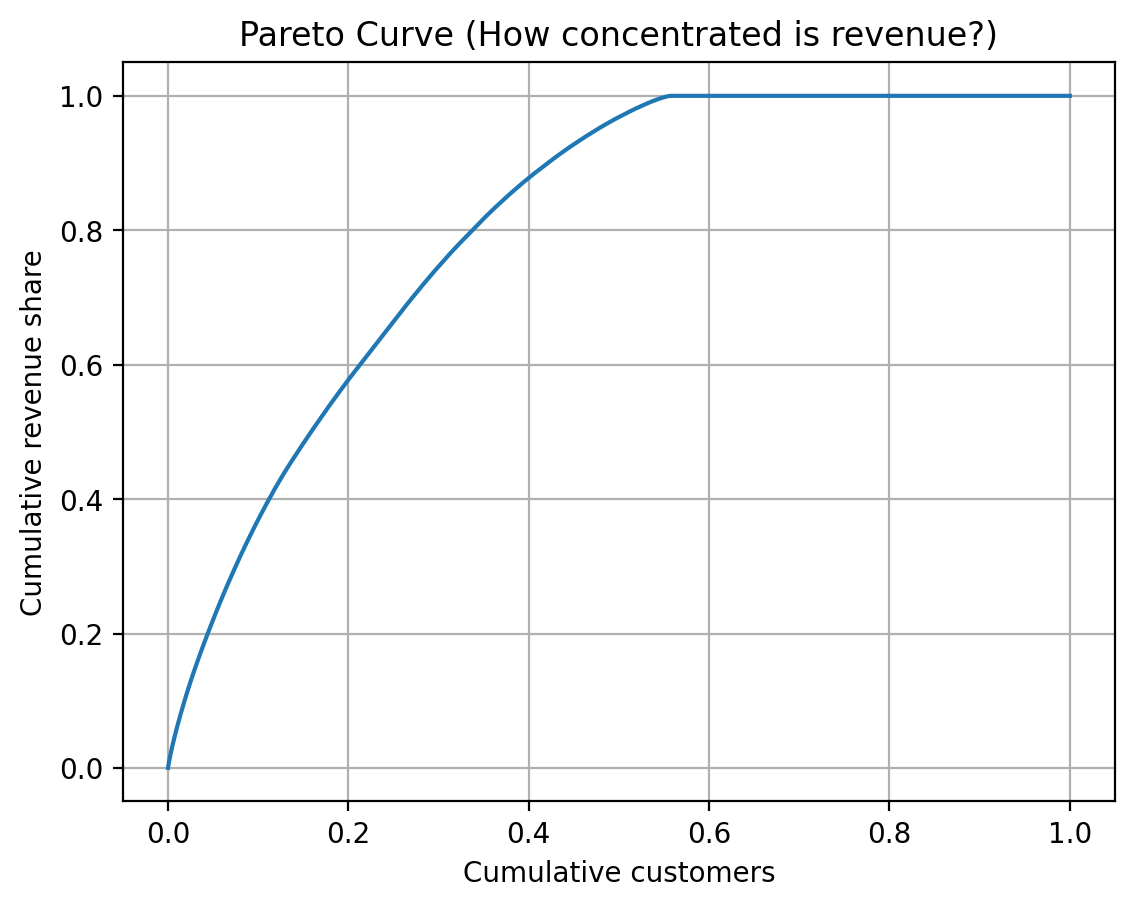

In [54]:
# 5) Pareto curve (cumulative customers vs cumulative revenue share)
pareto = rfm[["monetary"]].sort_values("monetary", ascending=False).reset_index(drop=True)
pareto["cum_rev"] = pareto["monetary"].cumsum() / pareto["monetary"].sum()
pareto["cum_cust"] = (np.arange(len(pareto)) + 1) / len(pareto)

plt.figure()
plt.plot(pareto["cum_cust"], pareto["cum_rev"])
plt.xlabel("Cumulative customers"); plt.ylabel("Cumulative revenue share")
plt.title("Pareto Curve (How concentrated is revenue?)"); plt.grid(True)

In [55]:
# =========================
# 2) Engagement features
# =========================
eng = ou.copy()
eng["hour"] = pd.to_datetime(eng[order_date_col], utc=True).dt.hour
eng["dow"]  = pd.to_datetime(eng[order_date_col], utc=True).dt.dayofweek
eng["is_weekend"] = eng["dow"] >= 5
eng["is_evening"] = eng["hour"].between(17, 22, inclusive="left")
eng["is_morning"] = eng["hour"].between(6, 12, inclusive="left")

# returns/cancels if status or timestamps exist
status_col = first_match(orders, ["status","state","order_status"])
ev = {
    "returned_at": first_match(orders, ["returned_at","returned","return_date","rma_date"]),
    "canceled_at": first_match(orders, ["canceled_at","cancelled","cancel_date"]),
}
ou_status = orders[[order_id, status_col] + [c for c in ev.values() if c]].copy() if status_col or any(ev.values()) else pd.DataFrame()
if not ou_status.empty:
    if status_col:
        s = ou_status[status_col].astype(str).str.lower()
        ou_status["is_cancel"] = s.str.contains("cancel")
        ou_status["is_return"] = s.str.contains("return")
    for k, c in ev.items():
        if c: ou_status[f"has_{k}"] = orders[c].notna()
    eng = eng.merge(ou_status[[order_id] + [c for c in ou_status.columns if c.startswith("is_") or c.startswith("has_")]],
                    on=order_id, how="left")

agg = (eng.groupby(order_user_fk, as_index=False)
         .agg(orders=("order_revenue","size"),
              weekend_share=("is_weekend","mean"),
              evening_share=("is_evening","mean"),
              morning_share=("is_morning","mean"),
              avg_order_hour=("hour","mean"),
              cancel_share=("is_cancel","mean") if "is_cancel" in eng.columns else ("order_revenue","size"),
              return_share=("is_return","mean") if "is_return" in eng.columns else ("order_revenue","size")))
if "cancel_share" in agg.columns and agg["cancel_share"].dtype != "float64":
    agg["cancel_share"] = np.nan
if "return_share" in agg.columns and agg["return_share"].dtype != "float64":
    agg["return_share"] = np.nan


In [56]:
# =========================
# 3) Demographics (gender, age, country)
# =========================
def build_age_years(df):
    df = df.copy()
    dob = pick_first(detect_columns(df, ["dob","birth","birthday","date_of_birth"]))
    if dob:
        df[dob] = pd.to_datetime(df[dob], errors="coerce")
        df["age_years"] = ((pd.Timestamp.today() - df[dob]).dt.days/365.25)
    if "age_years" not in df.columns or df["age_years"].isna().all():
        age_col = pick_first(detect_columns(df, ["age_years","age"]))
        if age_col:
            df["age_years"] = pd.to_numeric(df[age_col], errors="coerce")
    if "age_years" not in df.columns or df["age_years"].isna().all():
        y = pick_first(detect_columns(df, ["birth_year","yob","year_of_birth"]))
        if y:
            yr = pd.to_numeric(df[y], errors="coerce")
            dob_est = pd.to_datetime(dict(year=yr, month=6, day=15), errors="coerce")
            df["age_years"] = ((pd.Timestamp.today() - dob_est).dt.days/365.25)
    return df

users_demo = build_age_years(users)
if "email" in users_demo.columns:
    users_demo["email_domain"] = users_demo["email"].str.lower().str.extract(r'@(.+)$')

gender_col  = pick_first(detect_columns(users_demo, ["gender","sex"]))
country_col = pick_first(detect_columns(users_demo, ["country","country_code","nation","geo_country"]))
user_cols_keep = [c for c in [user_id, gender_col, country_col, "age_years", "email_domain"] if c]
demo = users_demo[user_cols_keep].drop_duplicates()

In [57]:
# =========================
# 4) Feature table + valuable / at-risk tags
# =========================
feat = (rfm.merge(agg, on=order_user_fk, how="left")
          .merge(demo, left_on=order_user_fk, right_on=user_id, how="left"))

feat["value_group"] = np.where(feat["segment"].isin(["VIP","Loyal"]), "valuable", "other")
feat["risk_group"]  = np.where(feat["segment"].eq("At Risk") | feat["is_at_risk"], "at_risk", "not_at_risk")

# Save features
feat.to_csv(os.path.join(OUT_DIR, "customer_features_segmented.csv"), index=False)


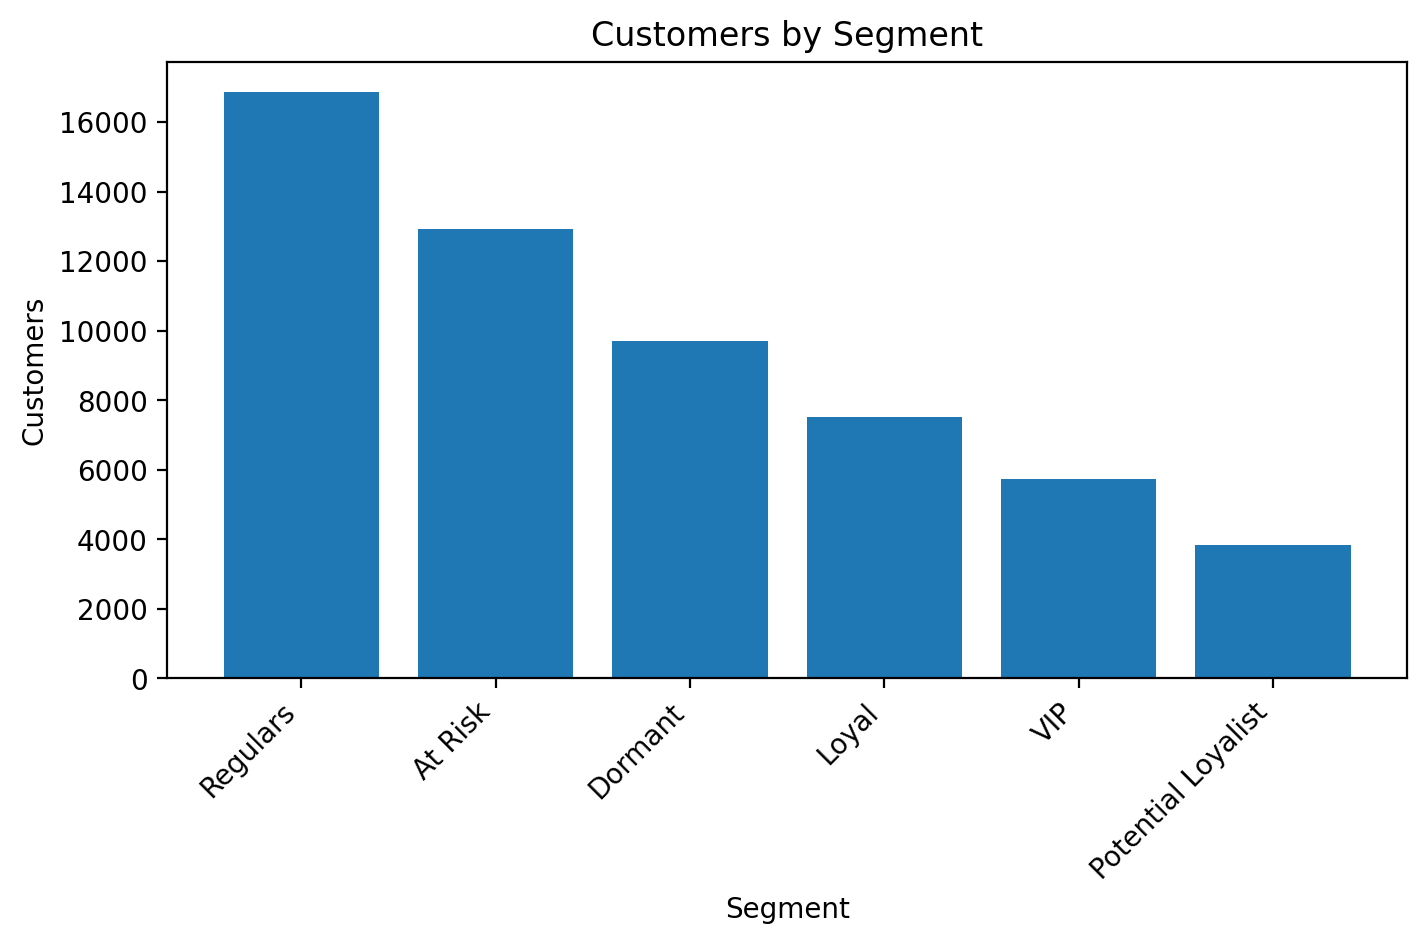

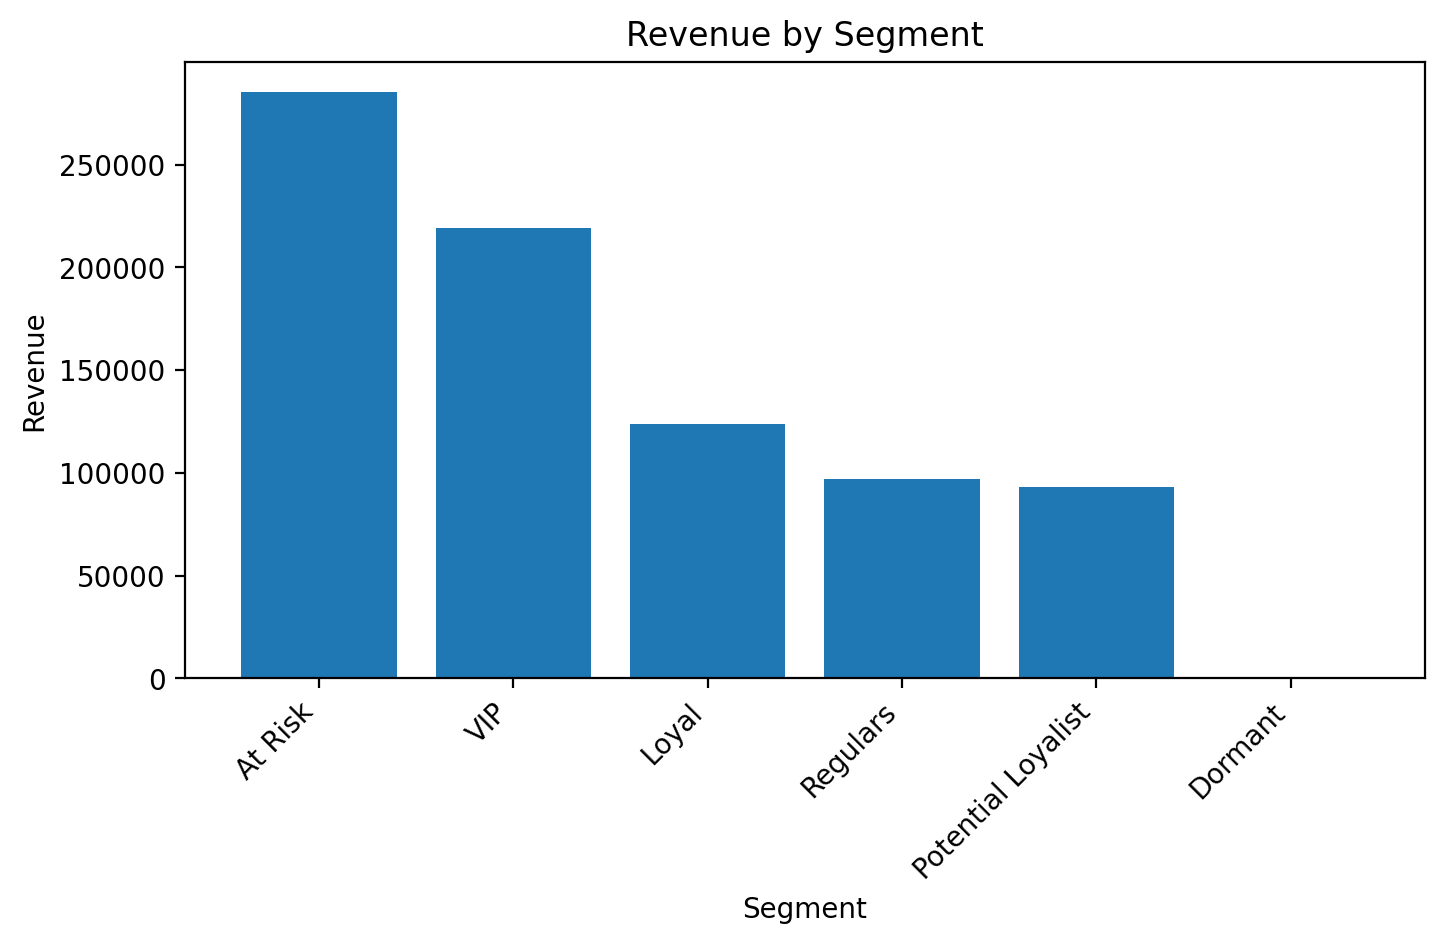

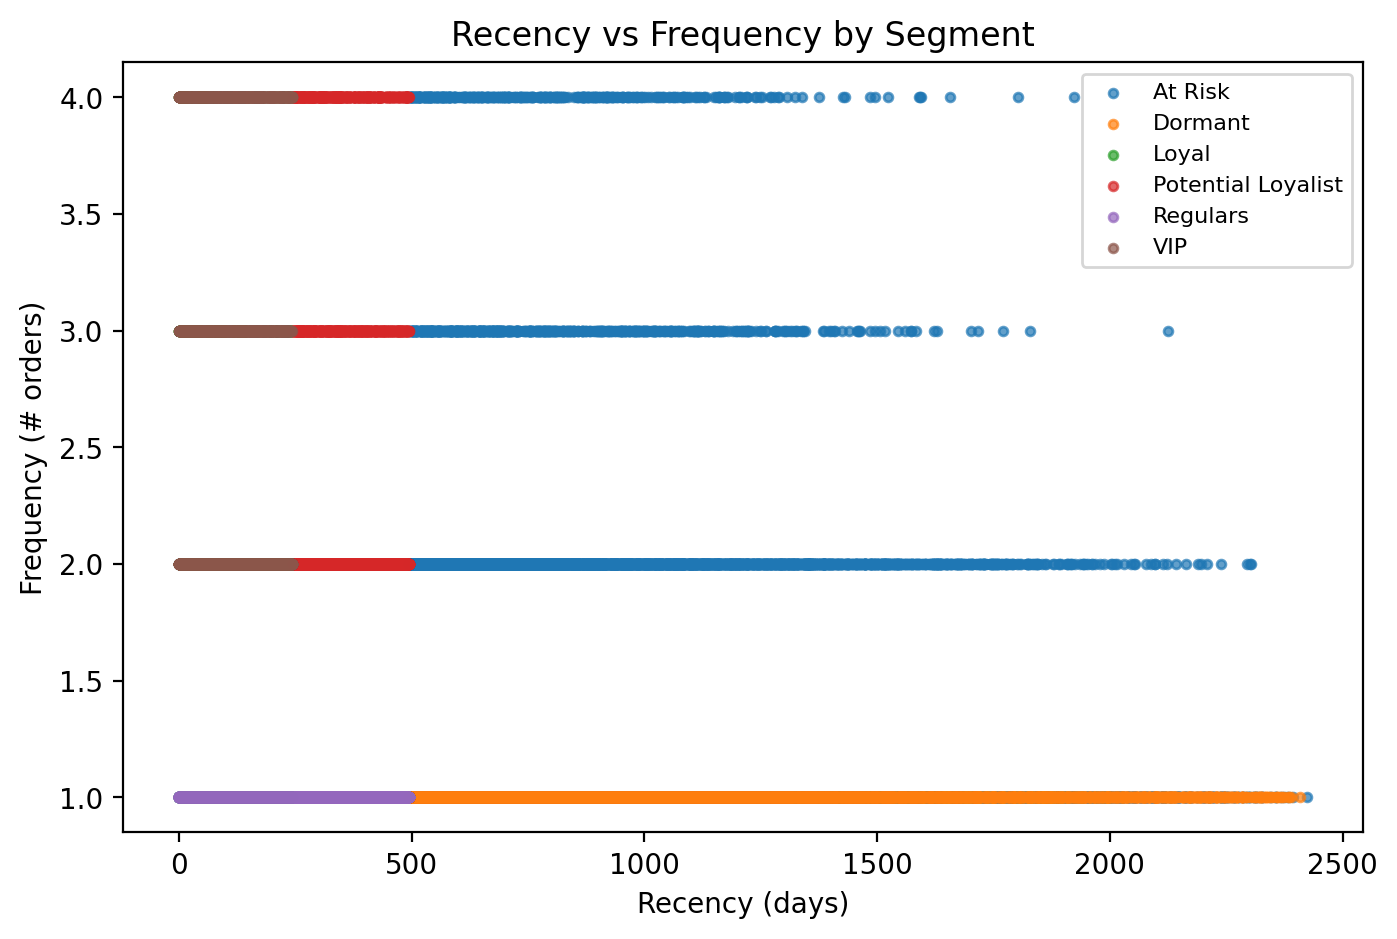

/var/folders/8s/kmd281414_3_sk09mpml3zvh0000gn/T/ipykernel_7707/284851780.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=seg_order, showfliers=False)


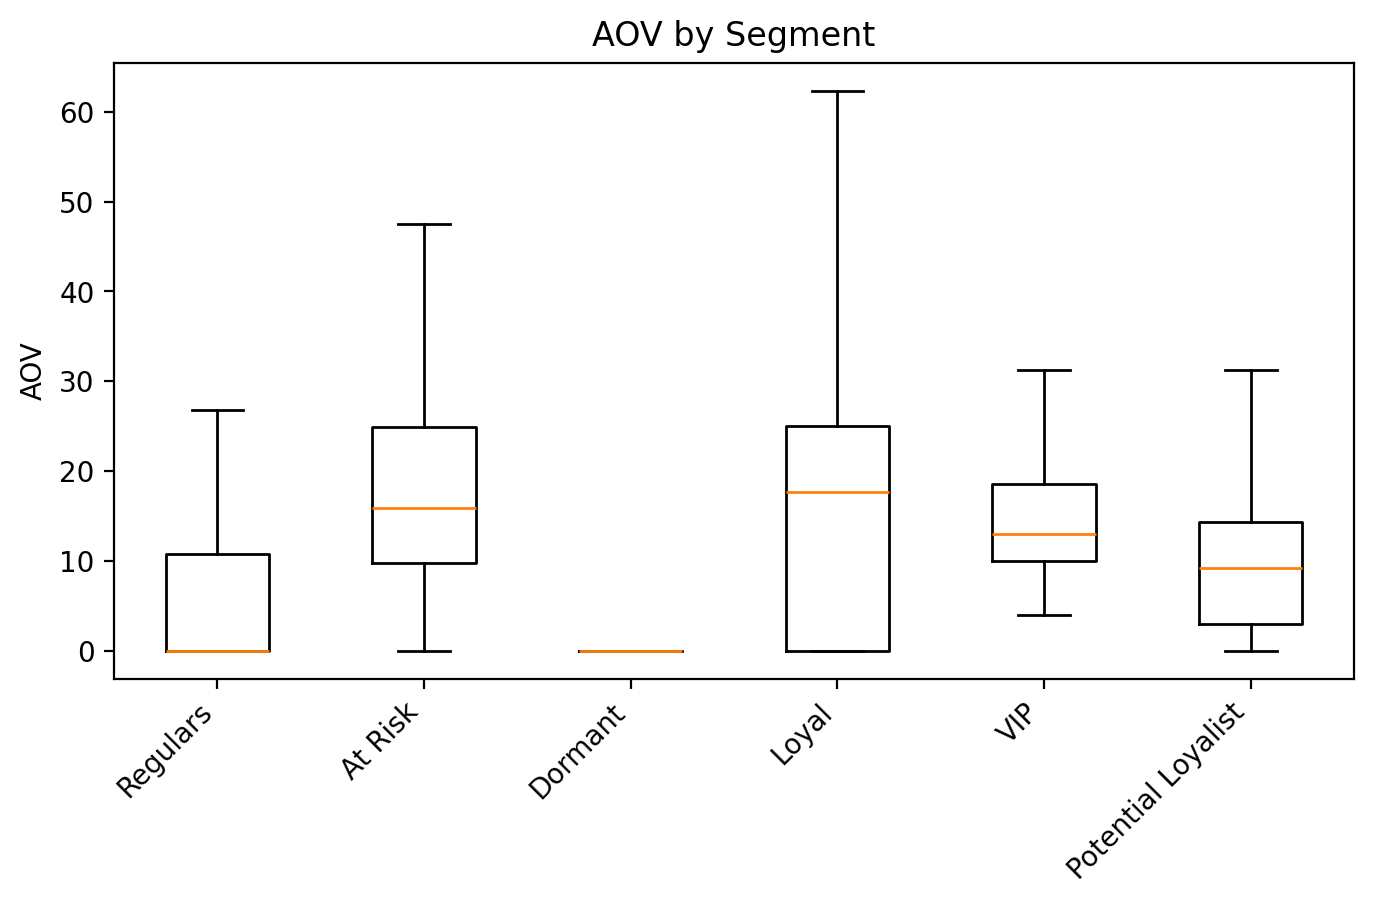

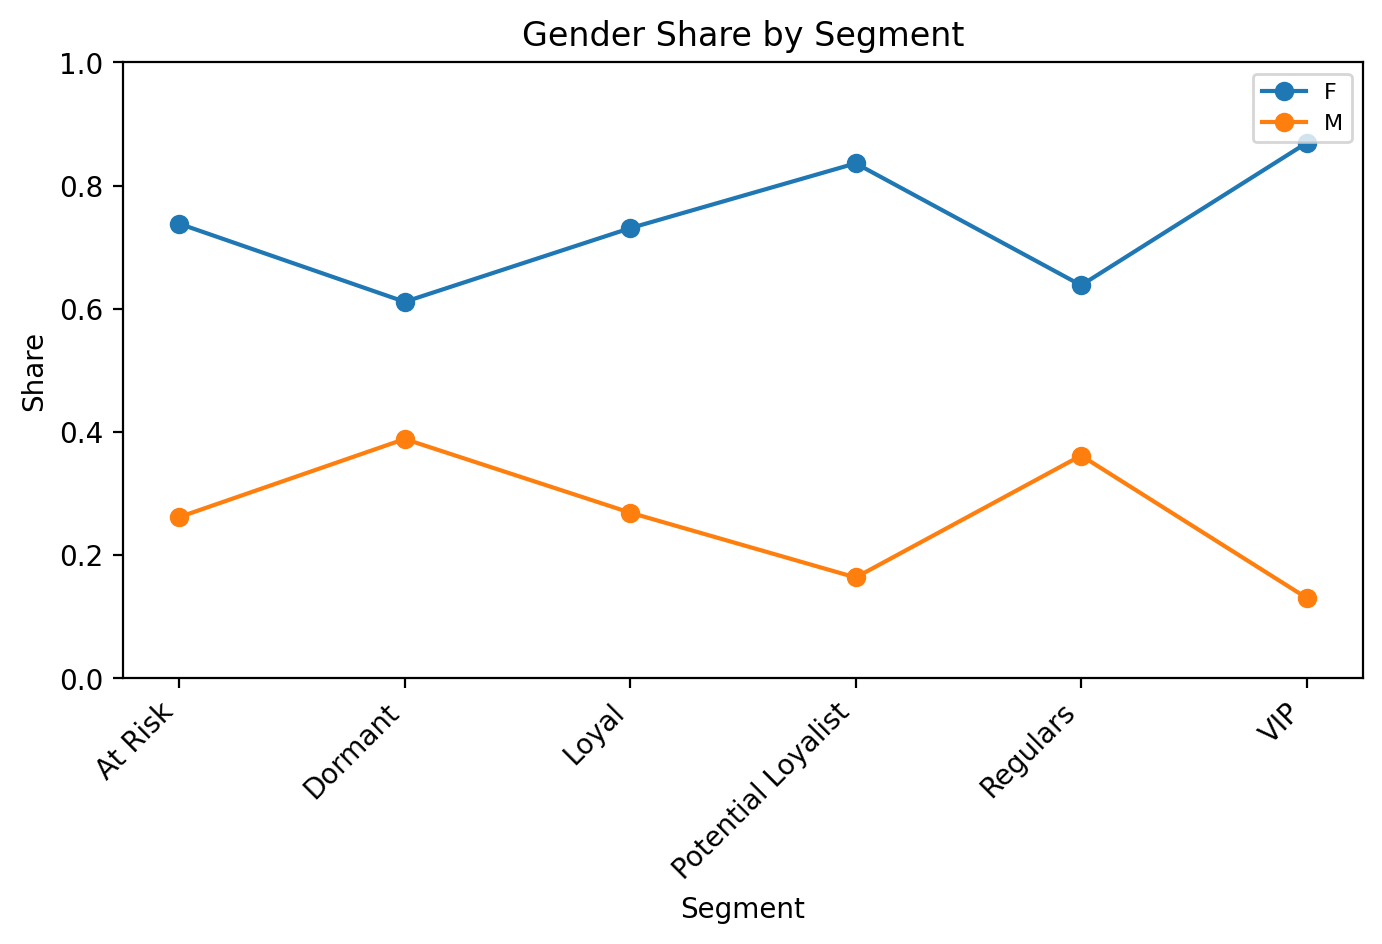

In [58]:
# =========================
# 5) Plots
# =========================
# Segment counts
seg_counts = feat["segment"].value_counts().rename_axis("segment").reset_index(name="customers")
fig = plt.figure(figsize=(8,4))
plt.bar(seg_counts["segment"].astype(str), seg_counts["customers"])
plt.xticks(rotation=45, ha="right"); plt.title("Customers by Segment"); plt.xlabel("Segment"); plt.ylabel("Customers")
finish_fig(fig, "seg_counts.png")

# Revenue by segment
seg_rev = feat.groupby("segment", as_index=False)["monetary"].sum().sort_values("monetary", ascending=False)
fig = plt.figure(figsize=(8,4))
plt.bar(seg_rev["segment"].astype(str), seg_rev["monetary"])
plt.xticks(rotation=45, ha="right"); plt.title("Revenue by Segment"); plt.xlabel("Segment"); plt.ylabel("Revenue")
finish_fig(fig, "seg_revenue.png")

# Recency vs Frequency scatter by segment (one legend)
fig = plt.figure(figsize=(8,5))
for seg, sub in feat.groupby("segment"):
    plt.scatter(sub["recency_days"], sub["frequency"], s=10, alpha=0.7, label=str(seg))
plt.xlabel("Recency (days)"); plt.ylabel("Frequency (# orders)"); plt.title("Recency vs Frequency by Segment")
plt.legend(loc="best", fontsize=8)
finish_fig(fig, "scatter_recency_frequency_by_segment.png")

# AOV by segment (boxplot)
seg_order = seg_counts["segment"].tolist()
box_data = [feat.loc[feat["segment"]==s, "aov"].dropna().values for s in seg_order]
fig = plt.figure(figsize=(8,4))
plt.boxplot(box_data, labels=seg_order, showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.title("AOV by Segment"); plt.ylabel("AOV")
finish_fig(fig, "box_aov_by_segment.png")

# Gender by segment (share)
if gender_col and gender_col in feat.columns:
    gtab = (feat.groupby(["segment", gender_col]).size().rename("n").reset_index())
    pivot = gtab.pivot(index="segment", columns=gender_col, values="n").fillna(0)
    pivot = (pivot.T / pivot.sum(axis=1)).T  # share within segment
    fig = plt.figure(figsize=(8,4))
    for i, col in enumerate(pivot.columns):
        plt.plot(pivot.index.astype(str), pivot[col].values, marker="o", label=str(col))
    plt.xticks(rotation=45, ha="right"); plt.ylim(0,1)
    plt.title("Gender Share by Segment"); plt.xlabel("Segment"); plt.ylabel("Share")
    plt.legend(loc="best", fontsize=8)
    finish_fig(fig, "gender_share_by_segment.png")

Per-customer measures

last_order_date: max completed order date

first_order_date: min completed order date

frequency: count of distinct completed orders

monetary: sum of order_revenue over completed orders

recency_days: (T − last_order_date) in days

AOV (not used for segment rules): monetary / frequency

interpurchase_median_days: median days between consecutive completed orders (if ≥2 orders)

global_median_gap: median of all interpurchase gaps across customers

churn_window_days: clip( 2 × interpurchase_median_days OR 2 × global_median_gap , 30, 180 )

Quintile scoring (R, F, M → 1..5)

Compute 20th/40th/60th/80th percentiles (q20, q40, q60, q80) across all customers (NaNs excluded) for each metric.

R (recency_days, lower is better — inverted):

r=5 if recency_days ≤ q20

r=4 if q20 < recency_days ≤ q40

r=3 if q40 < recency_days ≤ q60

r=2 if q60 < recency_days ≤ q80

r=1 if recency_days > q80

F (frequency, higher is better):

f=1 if frequency ≤ q20; …; f=5 if frequency > q80

M (monetary, higher is better):

m=1 if monetary ≤ q20; …; m=5 if monetary > q80

Segment assignment (apply in this order; first match wins)

VIP: r ≥ 4 AND f ≥ 4 AND m ≥ 4

Loyal: r ≥ 4 AND (f ≥ 4 OR m ≥ 4)

Potential Loyalist: r ≥ 3 AND f ≥ 3

At Risk: r ≤ 2 AND (f ≥ 3 OR m ≥ 3)

Dormant: r ≤ 2 AND f ≤ 2 AND m ≤ 2

Regulars: all others

Risk overlays (independent of the above label)

is_churned: recency_days > churn_window_days

is_at_risk: NOT is_churned AND recency_days > 0.75 × churn_window_days

Shorthands often used

Valuable = segment ∈ {VIP, Loyal}

At-risk cohort = is_at_risk == True (regardless of segment)

That’s the precise rulebook we run—no heuristics beyond the stated percentiles and the explicit precedence order above.

# Churn Prediction

In [59]:
# ==== ML CLV (Tweedie) — NaN-safe + RMSE-compat, with optional BG/NBD blend ====
import os, inspect, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------
# Compatibility + helpers
# -------------------------
def rmse_compat(y_true, y_pred):
    """Return RMSE regardless of sklearn version."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)  # newer sklearn
    except TypeError:
        return mean_squared_error(y_true, y_pred) ** 0.5          # older sklearn

def ohe_compat():
    """OneHotEncoder compatible with older/newer sklearn."""
    return (OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            if "sparse_output" in inspect.signature(OneHotEncoder).parameters
            else OneHotEncoder(handle_unknown="ignore", sparse=False))

def _eval(df, col):
    """Evaluate predictions in df[col] vs df['actual_clv_T'] using MAE/RMSE/Median APE."""
    yhat = df[col].values
    yact = df["actual_clv_T"].values
    mae  = mean_absolute_error(yact, yhat)
    rmse = rmse_compat(yact, yhat)
    mape = np.nanmedian(np.abs(yhat - yact) / np.where(yact == 0, np.nan, yact))
    return {"MAE": mae, "RMSE": rmse, "Median_APE": mape}

# -------------------------
# Domain-aware fills on `data`
# -------------------------
OUT_DIR = "./out"; os.makedirs(OUT_DIR, exist_ok=True)

data = data.copy()  # assumes `data` has columns incl. `actual_clv_T` and the features

# 1) Interpurchase median (when 1 order, it's NaN) → global median (fallback 60)
if "interpurchase_median_days" in data.columns:
    gm_ip = np.nanmedian(pd.to_numeric(data["interpurchase_median_days"], errors="coerce"))
    if not np.isfinite(gm_ip): gm_ip = 60.0
    data["interpurchase_median_days"] = pd.to_numeric(data["interpurchase_median_days"], errors="coerce").fillna(gm_ip)

# 2) Engagement in last 180d: if no activity, set to neutral
for c in ["orders","weekend_share","evening_share","morning_share"]:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce").fillna(0.0)

if "avg_order_hour" in data.columns:
    med_hr = np.nanmedian(pd.to_numeric(data["avg_order_hour"], errors="coerce"))
    if not np.isfinite(med_hr): med_hr = 12.0
    data["avg_order_hour"] = pd.to_numeric(data["avg_order_hour"], errors="coerce").fillna(med_hr)

# 3) AOV may be NaN when frequency==0; zero is safe for Tweedie
if "aov" in data.columns:
    data["aov"] = pd.to_numeric(data["aov"], errors="coerce").fillna(0.0)

# -------------------------
# Features & matrix
# -------------------------
feature_cols_num = [
    "recency_days","tenure_days","frequency","monetary","aov",
    "interpurchase_median_days","orders","weekend_share","evening_share",
    "morning_share","avg_order_hour"
]
if "age_years" in data.columns:
    feature_cols_num.append("age_years")
feature_cols_num = [c for c in feature_cols_num if c in data.columns]

feature_cols_cat = [c for c in ["gender","sex","country","country_code"] if c in data.columns]

# Ensure numerics are numeric
for c in feature_cols_num:
    data[c] = pd.to_numeric(data[c], errors="coerce")

X_mat = data[feature_cols_num + feature_cols_cat]
y_vec = data["actual_clv_T"].astype(float)

# -------------------------
# Preprocess + Tweedie model
# -------------------------
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), feature_cols_num),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("ohe", ohe_compat())
        ]), feature_cols_cat)
    ],
    remainder="drop"
)

tw_model = Pipeline([
    ("prep", pre),
    ("tw", TweedieRegressor(power=1.3, alpha=1e-3, max_iter=1000, link="log"))
])

Xtr, Xte, ytr, yte = train_test_split(X_mat, y_vec, test_size=0.25, random_state=42)
tw_model.fit(Xtr, ytr)
pred_te = np.clip(tw_model.predict(Xte), 0, None)

mae  = mean_absolute_error(yte, pred_te)
rmse = rmse_compat(yte, pred_te)
mape = np.nanmedian(np.abs(pred_te - yte) / np.where(yte==0, np.nan, yte))
print(f"ML CLV — MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | Median APE (ignore zeros): {mape:.2%}")

# -------------------------
# Predictions for all customers
# -------------------------
ml_pred_all = data[[cid]].copy()      # assumes `cid` holds the customer id column name
ml_pred_all["clv_T_ml"] = np.clip(tw_model.predict(X_mat), 0, None)

# -------------------------
# Blend with BG/NBD baseline if available
# -------------------------
# We’ll use labels straight from `data` to avoid relying on 'y'/'y_true' variable names.
y_join = data[[cid, "actual_clv_T"]].copy()

if 'bgnbd_pred' in globals() and isinstance(bgnbd_pred, pd.DataFrame) and (cid in bgnbd_pred.columns):
    pred = (bgnbd_pred.merge(ml_pred_all, on=cid, how="outer")
                      .merge(y_join, on=cid, how="left")
                      .fillna({"actual_clv_T": 0}))
    pred["clv_T_blend"] = 0.5*pred["clv_T_bgnbd"].fillna(0) + 0.5*pred["clv_T_ml"].fillna(0)

    # Evaluate all three where available
    results = {}
    if "clv_T_bgnbd" in pred.columns:
        results["BG/NBD"] = _eval(pred, "clv_T_bgnbd")
    results["ML"] = _eval(pred, "clv_T_ml")
    results["Blend"] = _eval(pred, "clv_T_blend")
    print(results)

    # Save predictions
    export_cols = [c for c in [cid,"exp_purch_T","exp_aov","p_alive","clv_T_bgnbd","clv_T_ml","clv_T_blend","actual_clv_T"] if c in pred.columns]
    pred[export_cols].to_csv(os.path.join(OUT_DIR, "predicted_clv_90d.csv"), index=False)
    print("Saved:", os.path.join(OUT_DIR, "predicted_clv_90d.csv"))
else:
    # ML-only fallback export
    ml_only = ml_pred_all.merge(y_join, on=cid, how="left")
    ml_only.to_csv(os.path.join(OUT_DIR, "predicted_clv_ml_only_90d.csv"), index=False)
    print("Saved ML-only predictions:", os.path.join(OUT_DIR, "predicted_clv_ml_only_90d.csv"))


ML CLV — MAE: 0.51 | RMSE: 2.79 | Median APE (ignore zeros): 98.82%
{'BG/NBD': {'MAE': 0.4126381656265464, 'RMSE': 2.7009589737085613, 'Median_APE': np.float64(0.9922225477895746)}, 'ML': {'MAE': 0.5105771248031866, 'RMSE': 2.688235582996361, 'Median_APE': np.float64(0.9846200793262019)}, 'Blend': {'MAE': 0.4616076452148665, 'RMSE': 2.6902259544886618, 'Median_APE': np.float64(0.9881257470662974)}}
Saved: ./out/predicted_clv_90d.csv
